# 📊 A Comparative Analysis of Traditional and Custom Hyperparameter Tuning Techniques for LSTM and GRU Models in Time Series Forecasting

This notebook presents the implementation and experimental workflow of my Master's thesis.  
The primary goal is to evaluate the effectiveness of different **hyperparameter tuning strategies** for deep learning models applied to **short-term electricity load forecasting**.  

We focus on two widely used recurrent neural network architectures:  
- **Long Short-Term Memory (LSTM)**  
- **Gated Recurrent Unit (GRU)**  

and compare their performance under various tuning methods:  
- 🔹 Grid Search  
- 🔹 Random Search  
- 🔹 Bayesian Optimization (via KerasTuner)  
- 🔹 Tree-structured Parzen Estimator (via Optuna)  

By integrating electricity consumption data with exogenous temperature variables, the study investigates:  
- The impact of **hyperparameter optimization** on model performance    
- The robustness of LSTM vs. GRU across different split strategies (70/15/15 and 75/15/10)  

The following sections of this notebook reproduce the data preprocessing, exploratory analysis, model building, and tuning experiments that form the foundation of the thesis.  


## Importing Libraries

We import the required libraries for:  
- Data handling & preprocessing (`pandas`, `numpy`, `sklearn`)  
- Visualization (`matplotlib`, `seaborn`)  
- Deep learning models (`TensorFlow/Keras`)  
- Hyperparameter tuning (`Optuna`, `KerasTuner`, `GridSearchCV`)  
- External data (weather) from `meteostat`  


In [3]:
# Core Libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Date & Time
from datetime import datetime

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Hyperparameter Tuning
import optuna
import keras_tuner as kt
from sklearn.model_selection import GridSearchCV

# External Data Source (Weather)
from meteostat import Point, Daily

## Reproducibility(SEED) 
Setting a fixed random seed ensures consistent and repeatable results.  

In [5]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [6]:
# Read a file
df = pd.read_csv("LD2011_2014.txt",
                 sep=';',           
                 decimal=',',       
                 index_col=0,       
                 parse_dates=True,  
                 quotechar='"'      
                 )

print("="*50)
print("First Five Rows ","\n")
print(df.head(),"\n")

print("="*50)
print("Information About Data Set","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Data Set","\n")
print(df.describe(),"\n")          

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   

                     MT_364  MT_365  MT_366  MT_3

# Determine the First Valid (Non-Zero) Entry Date for Each Client

In [8]:
first_nonzero_dates = df[df > 0].apply(lambda col: col.first_valid_index())
pd.set_option('display.max_rows', 400)  # including all clients
print(first_nonzero_dates)

MT_001   2012-01-01 00:15:00
MT_002   2012-01-01 00:15:00
MT_003   2012-01-01 00:15:00
MT_004   2012-01-01 00:15:00
MT_005   2012-01-01 00:15:00
MT_006   2012-01-01 00:15:00
MT_007   2012-01-01 00:15:00
MT_008   2012-01-01 00:15:00
MT_009   2012-01-01 00:15:00
MT_010   2012-01-01 00:15:00
MT_011   2012-01-01 00:15:00
MT_012   2013-08-29 14:15:00
MT_013   2012-01-01 00:15:00
MT_014   2012-01-01 00:15:00
MT_015   2013-06-04 14:45:00
MT_016   2012-01-01 00:15:00
MT_017   2012-01-01 00:15:00
MT_018   2012-01-01 00:15:00
MT_019   2012-01-01 00:15:00
MT_020   2012-01-01 00:15:00
MT_021   2012-01-01 00:15:00
MT_022   2012-01-01 00:15:00
MT_023   2012-01-01 00:15:00
MT_024   2012-03-30 11:15:00
MT_025   2012-01-01 00:15:00
MT_026   2012-01-01 00:15:00
MT_027   2012-01-01 00:15:00
MT_028   2012-01-01 00:15:00
MT_029   2012-01-01 00:15:00
MT_030   2013-05-09 14:30:00
MT_031   2012-01-01 00:15:00
MT_032   2012-11-16 14:30:00
MT_033   2012-07-13 14:45:00
MT_034   2012-01-01 00:15:00
MT_035   2012-

#### Client Selection  
Identifying clients with the most complete data; MT_321 was selected for analysis.  

# MT_321

##### Data Transformation  
Convert MT_321 from 15-min kW readings to hourly kWh by dividing by 4 and aggregating.  

In [12]:
df_mt_321 = df[['MT_321']].copy()
df_321_kwh = df_mt_321 / 4                           # ( TO CONVERT KW>>>KWH)
df_hourly_kwh_321 = df_321_kwh.resample('h').sum()   # ( TO CONVERT HOURLY )
df_321 =  df_hourly_kwh_321
 

print("="*50)
print("First Five Rows ","\n")
print(df_321.head(),"\n")

print("="*50)
print("Information About Data Set","\n")
print(df_321.info(),"\n")

print("="*50)
print("Describe the Client 321","\n")
print(df_321.describe(),"\n")


First Five Rows  

                        MT_321
2011-01-01 00:00:00  42.379679
2011-01-01 01:00:00  59.054622
2011-01-01 02:00:00  61.923224
2011-01-01 03:00:00  59.054622
2011-01-01 04:00:00  62.307105 

Information About Data Set 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35065 entries, 2011-01-01 00:00:00 to 2015-01-01 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MT_321  35065 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB
None 

Describe the Client 321 

             MT_321
count  35065.000000
mean     112.895217
std       35.059143
min        0.954927
25%       76.829641
50%      121.493506
75%      139.618029
max      246.176471 



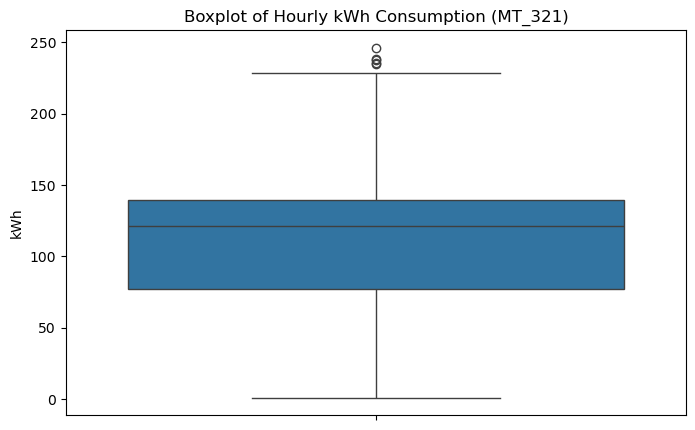

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_321['MT_321'])
plt.title("Boxplot of Hourly kWh Consumption (MT_321)")
plt.ylabel("kWh")
plt.show()

## Outlier Handling Decision  
Although some hourly values appear as outliers (~1 kWh or ~240 kWh), 
they were retained since such extreme fluctuations are natural in electricity consumption and may contain meaningful patterns for forecasting.
Removing them could lead to information loss and biased results

 # Reformat the Data Time Colums for EDA

In [16]:
# Extract all Data Like Year Month Day Time etc
dataset = df_321
dataset["Month"] = pd.to_datetime(df_321.index).month
dataset["Year"] = pd.to_datetime(df_321.index).year
dataset["Date"] = pd.to_datetime(df_321.index).date
dataset["Time"] = pd.to_datetime(df_321.index).time
dataset["Week"] = pd.to_datetime(df_321.index).isocalendar().week
dataset["Day"] = pd.to_datetime(df_321.index).day_name()

dataset.head(3)

,MT_321,Month,Year,Date,Time,Week,Day
2011-01-01 00:00:00,42.379679,1,2011,2011-01-01,00:00:00,52,Saturday
2011-01-01 01:00:00,59.054622,1,2011,2011-01-01,01:00:00,52,Saturday
2011-01-01 02:00:00,61.923224,1,2011,2011-01-01,02:00:00,52,Saturday


In [17]:
dataset.tail(3)

,MT_321,Month,Year,Date,Time,Week,Day
2014-12-31 22:00:00,58.101604,12,2014,2014-12-31,22:00:00,1,Wednesday
2014-12-31 23:00:00,54.087089,12,2014,2014-12-31,23:00:00,1,Wednesday
2015-01-01 00:00:00,11.514515,1,2015,2015-01-01,00:00:00,1,Thursday


In [18]:
#Deleting 2015-01-01 
dataset = dataset[dataset['Year'] < 2015]
print(dataset.Year.unique(), "\n")
print("Total number of Unique Year", dataset.Year.nunique(), "\n")

[2011 2012 2013 2014] 

Total number of Unique Year 4 



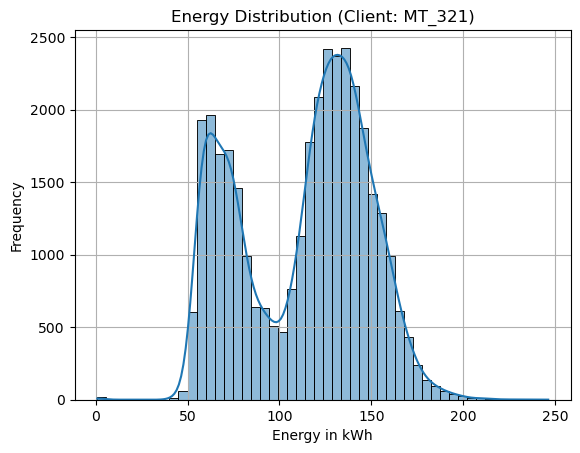

In [19]:
sns.histplot(dataset["MT_321"], kde=True, bins=50)
plt.title("Energy Distribution (Client: MT_321)")
plt.xlabel("Energy in kWh")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


**Notes:**

- The distribution is **bimodal**, showing two distinct peaks.  
- The first peak (~50–80 kWh) corresponds to **low consumption periods** (night/early morning).  
- The second peak (~120–150 kWh) corresponds to **high consumption periods** (daytime/active hours).


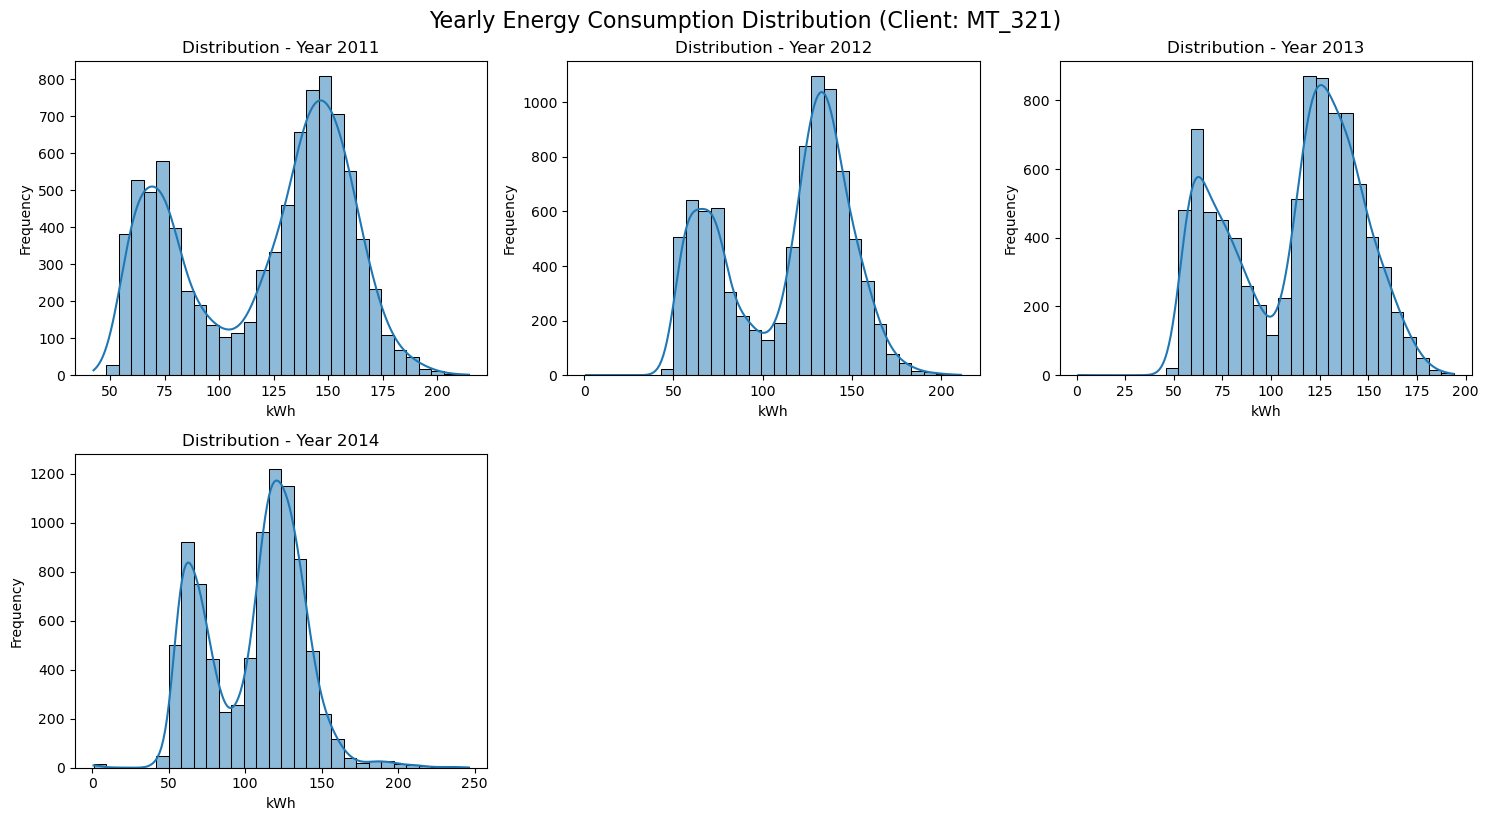

<Figure size 640x480 with 0 Axes>

In [21]:
# get all years
years = dataset["Year"].unique()
plt.figure(figsize=(15, 8))
# subplot for every year
for i, year in enumerate(sorted(years)):
    plt.subplot(2, 3, i+1)  
    sns.histplot(dataset[dataset["Year"] == year]["MT_321"], kde=True, bins=30)
    plt.title(f"Distribution - Year {year}")
    plt.xlabel("kWh")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Yearly Energy Consumption Distribution (Client: MT_321)", fontsize=16, y=1.02)
plt.show()
plt.subplots_adjust(top=0.88)

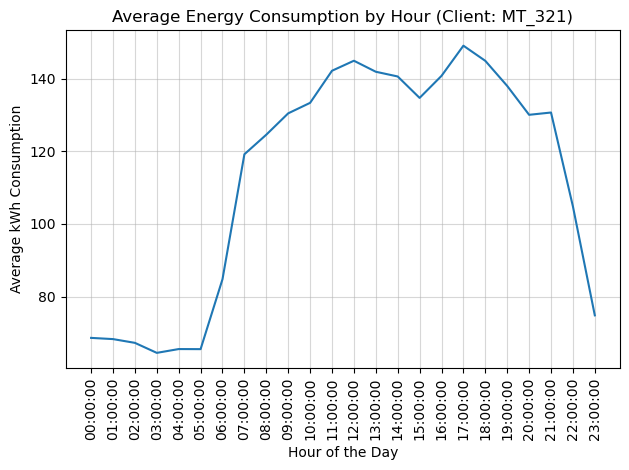

In [22]:
# getting hourly avarage
hourly_avg = dataset.groupby("Time")["MT_321"].mean().reset_index()
hourly_avg["Time"] = hourly_avg["Time"].astype(str)  # string
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.lineplot(x="Time", y="MT_321", data=hourly_avg)
plt.title("Average Energy Consumption by Hour (Client: MT_321)")
plt.xlabel("Hour of the Day")
plt.ylabel("Average kWh Consumption")
plt.grid(True, alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Notes:**

- Energy consumption remains **low during night hours** (00:00–05:00).  
- A **sharp increase** occurs in the morning starting around 06:00.  
- Consumption reaches its **peak between 11:00 and 18:00**, indicating high daytime activity.  
- After 21:00, consumption **gradually decreases** back to lower levels.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



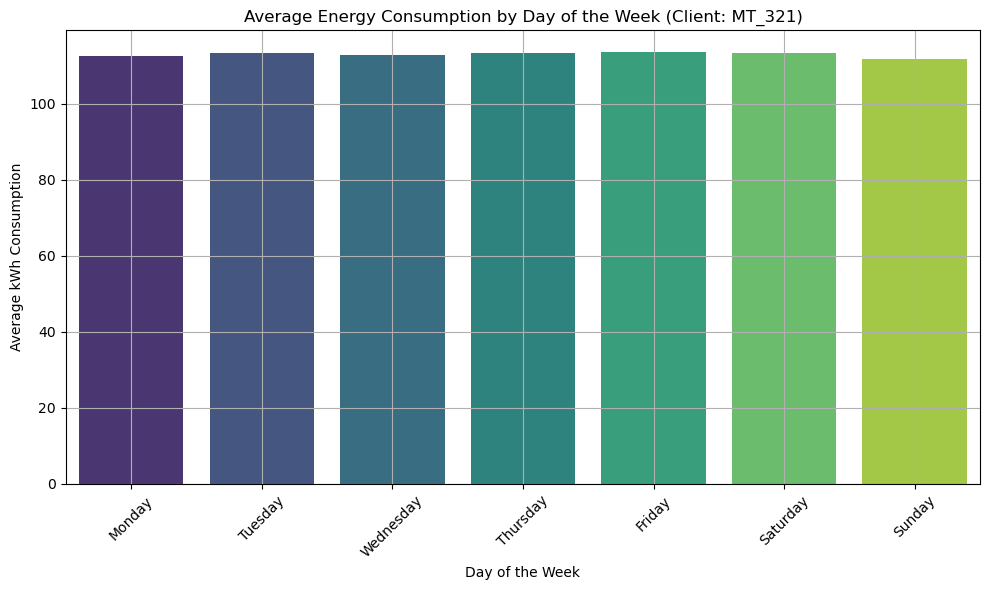

In [24]:
# ("Average Energy Consumption by Day of the Week (Client: MT_321
daily_avg = dataset.groupby("Day")["MT_321"].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.barplot(x=daily_avg.index, y=daily_avg.values, palette="viridis")
plt.title("Average Energy Consumption by Day of the Week (Client: MT_321)")
plt.xlabel("Day of the Week")
plt.ylabel("Average kWh Consumption")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Notes:**

- **Consumption behavior by hour is very distinct** → low (night) and high (daytime) regimes exist.  
- **Consumption behavior by day is stable** → the day of the week has almost no effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



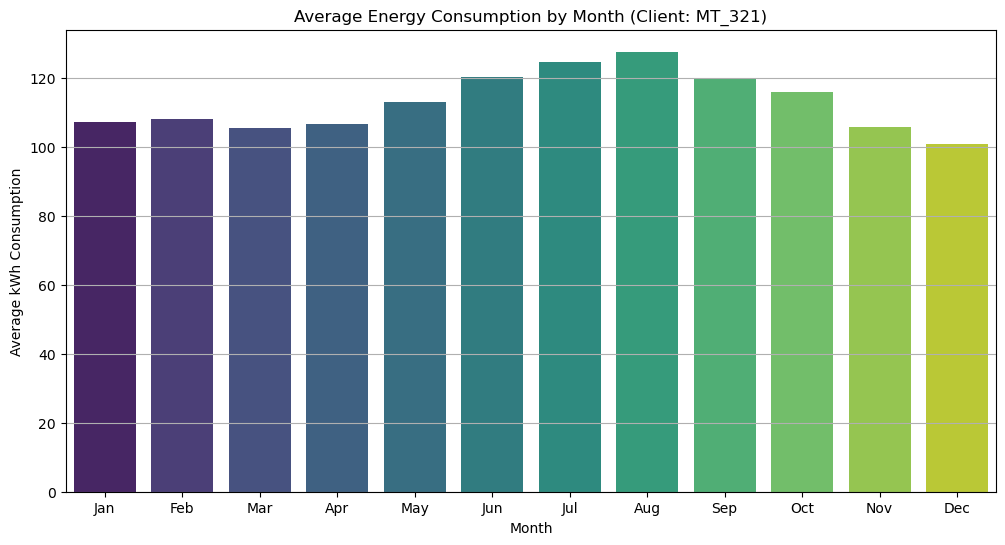

In [26]:
# Average Energy Consumption by Month (Client: MT_321)
monthly_avg = dataset.groupby("Month")["MT_321"].mean().reset_index()

month_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Grafiği çiz
plt.figure(figsize=(12, 6))
sns.barplot(x="Month", y="MT_321", data=monthly_avg, order=month_order, palette="viridis")
plt.xticks(ticks=range(12), labels=month_labels)
plt.title("Average Energy Consumption by Month (Client: MT_321)")
plt.xlabel("Month")
plt.ylabel("Average kWh Consumption")
plt.grid(True, axis='y')
plt.show()


**Notes:**

- Energy consumption is **lower in winter months** (Dec–Mar).  
- Consumption **gradually increases from spring**, reaching its **peak in summer (Jul–Aug)**.  
- After August, consumption **declines again towards the end of the year**.  
- This pattern suggests a **seasonal effect**, likely influenced by heating/cooling needs.


Text(0.5, 1.0, 'Hourly Energy Consumption by Day of Week')

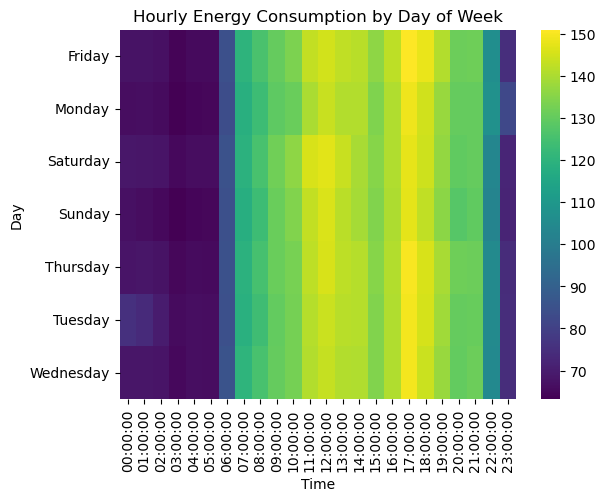

In [28]:
heatmap_data = dataset.pivot_table(index='Day', columns='Time', values='MT_321', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='viridis')
plt.title("Hourly Energy Consumption by Day of Week")


**Notes:**

- Across all days, energy consumption is **low during night hours** (00:00–05:00).  
- From around **06:00 onwards**, consumption increases sharply.  
- The **highest consumption levels occur between 11:00 and 19:00** across all days.  
- There is **no significant difference between weekdays and weekends**, confirming a consistent daily pattern.

# Converting hourly data to daily data

In [31]:
dataset.head(3)

,MT_321,Month,Year,Date,Time,Week,Day
2011-01-01 00:00:00,42.379679,1,2011,2011-01-01,00:00:00,52,Saturday
2011-01-01 01:00:00,59.054622,1,2011,2011-01-01,01:00:00,52,Saturday
2011-01-01 02:00:00,61.923224,1,2011,2011-01-01,02:00:00,52,Saturday


### Daily Aggregation  
Converted hourly consumption into daily totals, as time series forecasting is performed at the daily level.  

In [33]:
dataset_clean = dataset.drop(columns=['Time'], errors='ignore')

daily_df = dataset_clean[['MT_321']].resample('D').sum()

daily_df['Year'] = daily_df.index.year
daily_df['Month'] = daily_df.index.month
daily_df['Day'] = daily_df.index.day_name()  # 'Monday', 'Tuesday' vs.

print("="*50)
print("First Three Rows ","\n")
print(daily_df.tail(3),"\n")

print("="*50)
print("Describe the Client 321","\n")
print(daily_df.describe(),"\n")

First Three Rows  

                 MT_321  Year  Month        Day
2014-12-29  2490.527120  2014     12     Monday
2014-12-30  2561.680672  2014     12    Tuesday
2014-12-31  2513.829259  2014     12  Wednesday 

Describe the Client 321 

            MT_321         Year        Month
count  1461.000000  1461.000000  1461.000000
mean   2709.554595  2012.499658     6.522930
std     284.048939     1.118111     3.449884
min    1415.991215  2011.000000     1.000000
25%    2493.943850  2012.000000     4.000000
50%    2687.362490  2012.000000     7.000000
75%    2927.847594  2013.000000    10.000000
max    3585.036287  2014.000000    12.000000 



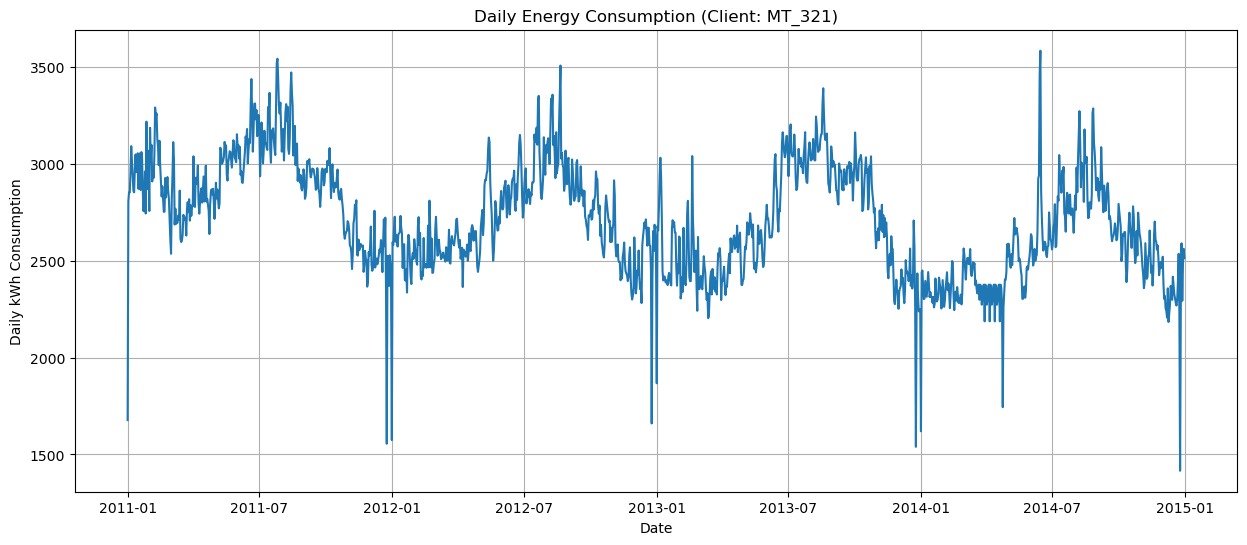

In [34]:
# Daily time series plot
plt.figure(figsize=(15,6))
plt.plot(daily_df.index, daily_df['MT_321'], color="tab:blue")
plt.title("Daily Energy Consumption (Client: MT_321)")
plt.xlabel("Date")
plt.ylabel("Daily kWh Consumption")
plt.grid(True)
plt.show()

# Using Daily temperature as exogenuons

In [36]:
!pip install meteostat

In [37]:
from datetime import datetime
from meteostat import Point, Daily, Stations


Stations.max_age = 0
Daily.max_age = 0

# Lisbon 
lisbon = Point(38.7169, -9.1399)


start = datetime(2011, 1, 1)
end   = datetime(2015, 1, 1)


data = Daily(lisbon, start, end).fetch()


temperature_df = data[["tavg"]].reset_index()
temperature_df.columns = ["Date", "Avg_Temperature_C"]

# 2015 öncesini filtrele
temperature_df = temperature_df[temperature_df['Date'] < '2015-01-01']

temperature_df.tail()


,Date,Avg_Temperature_C
1456,2014-12-27,11.5
1457,2014-12-28,12.3
1458,2014-12-29,8.3
1459,2014-12-30,6.2
1460,2014-12-31,6.8


# Convert to Index

In [39]:
temperature_df['Date'] = pd.to_datetime(temperature_df['Date'])  
temperature_df.set_index('Date', inplace=True)
temperature_df.head()

,Avg_Temperature_C
Date,
2011-01-01,13.7
2011-01-02,10.5
2011-01-03,11.2
2011-01-04,13.4
2011-01-05,15.4


In [40]:
temperature_df.describe()

,Avg_Temperature_C
count,1461.0
mean,16.837988
std,4.738317
min,6.1
25%,12.9
50%,16.7
75%,20.5
max,31.2


# Merging Datasets

In [42]:
merged_df = daily_df.merge(temperature_df, left_index=True, right_index=True)
print(len(merged_df))  # 1461
print(merged_df.isnull().sum())  # 0 null 

1461
MT_321               0
Year                 0
Month                0
Day                  0
Avg_Temperature_C    0
dtype: int64


In [43]:
merged_df.head()

,MT_321,Year,Month,Day,Avg_Temperature_C
2011-01-01,1677.597403,2011,1,Saturday,13.7
2011-01-02,2807.946906,2011,1,Sunday,10.5
2011-01-03,2854.337280,2011,1,Monday,11.2
2011-01-04,2852.967914,2011,1,Tuesday,13.4
2011-01-05,2961.946142,2011,1,Wednesday,15.4


 # Granger Causality between MT_321 and Temperature

In [36]:
grangercausalitytests(merged_df[['MT_321', 'Avg_Temperature_C']], maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=69.0067 , p=0.0000  , df_denom=1457, df_num=1
ssr based chi2 test:   chi2=69.1488 , p=0.0000  , df=1
likelihood ratio test: chi2=67.5612 , p=0.0000  , df=1
parameter F test:         F=69.0067 , p=0.0000  , df_denom=1457, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=28.0262 , p=0.0000  , df_denom=1454, df_num=2
ssr based chi2 test:   chi2=56.2453 , p=0.0000  , df=2
likelihood ratio test: chi2=55.1882 , p=0.0000  , df=2
parameter F test:         F=28.0262 , p=0.0000  , df_denom=1454, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=19.3340 , p=0.0000  , df_denom=1451, df_num=3
ssr based chi2 test:   chi2=58.2820 , p=0.0000  , df=3
likelihood ratio test: chi2=57.1472 , p=0.0000  , df=3
parameter F test:         F=19.3340 , p=0.0000  , df_denom=1451, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.1570 , p=0.

{1: ({'ssr_ftest': (69.00673455071069, 2.2172014560276682e-16, 1457.0, 1),
   'ssr_chi2test': (69.14882116955224, 9.130692409829243e-17, 1),
   'lrtest': (67.56123551279597, 2.0424401569436107e-16, 1),
   'params_ftest': (69.00673455071156, 2.2172014560267544e-16, 1457.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (28.026249103581815, 1.1405280891391788e-12, 1454.0, 2),
   'ssr_chi2test': (56.245250952030084, 6.116443088695495e-13, 2),
   'lrtest': (55.18818964007005, 1.037616541419717e-12, 2),
   'params_ftest': (28.026249103582003, 1.1405280891389722e-12, 1454.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (19.33404651190982, 2.7094801807215158e-12, 1451.0, 3),
   'ssr_chi2test': (58.281956887038966, 1.3683892492634306e-12, 3),
   'lrtest': (57.14721940229356, 2.390485155586777e-12, 3),
   'params_ftest': (19.334046511909634, 2.709480180722209e-12, 1451.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0.

### Interpretation  
The Granger test confirms that temperature Granger-causes electricity consumption: incorporating lagged temperature values significantly improves load forecasting, especially at shorter lags (e.g., lag 1).  


# Pearson Correlation Heat Map

Pearson Correlation Coefficient: 0.7196
P-value: 0.0000


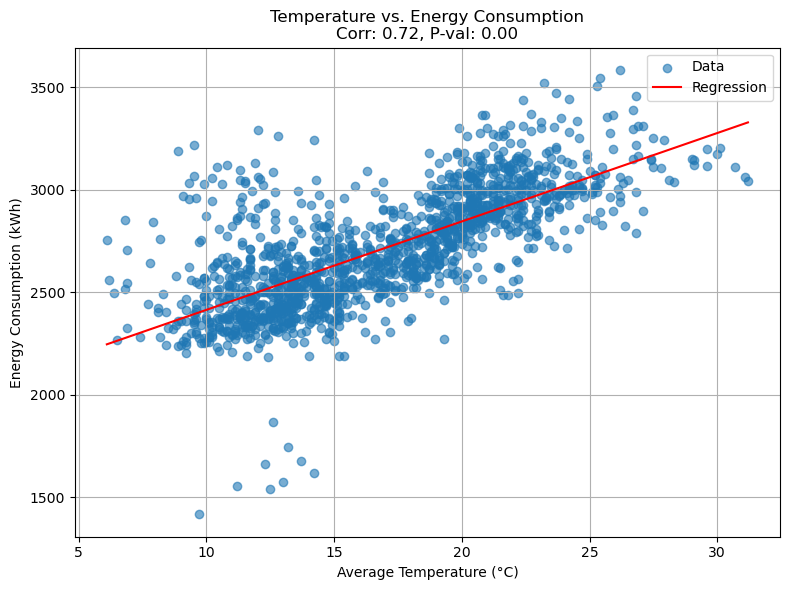

(0.7196206000522588, 2.1945711650454016e-233)

In [75]:
from scipy.stats import pearsonr


def temperature_consumption_correlation(df,
                                        temp_col='Avg_Temperature_C',
                                        cons_col='MT_321'):
 
    df = df.sort_index().copy()

    
    df[temp_col] = pd.to_numeric(df[temp_col], errors='coerce')
    df[cons_col] = pd.to_numeric(df[cons_col], errors='coerce')
    df = df.dropna(subset=[temp_col, cons_col])

    # 3) Pearson correlation
    corr, p_value = pearsonr(df[temp_col].values, df[cons_col].values)

    # 4) 
    print(f"Pearson Correlation Coefficient: {corr:.4f}")
    print(f"P-value: {p_value:.4f}")

    # 5) Scatter plot + regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(df[temp_col], df[cons_col], alpha=0.6, label="Data")

    # Regresyon line
    coeffs = np.polyfit(df[temp_col], df[cons_col], deg=1)
    x_line = np.linspace(df[temp_col].min(), df[temp_col].max(), 100)
    y_line = coeffs[0] * x_line + coeffs[1]
    plt.plot(x_line, y_line, color="red", label="Regression")

    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Energy Consumption (kWh)')
    plt.title(f'Temperature vs. Energy Consumption\nCorr: {corr:.2f}, P-val: {p_value:.2f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return corr, p_value


temperature_consumption_correlation(merged_df)


#### Temperature–Load Correlation  
Pearson correlation of 0.72 (p<0.001) indicates a strong positive relationship: higher average temperatures are associated with higher daily electricity consumption.  

In [77]:
#merged on dates
merged_df = daily_df.merge(temperature_df, left_index=True, right_index=True)
merged_df.head()

,MT_321,Year,Month,Day,Avg_Temperature_C
2011-01-01,1677.597403,2011,1,Saturday,13.7
2011-01-02,2807.946906,2011,1,Sunday,10.5
2011-01-03,2854.337280,2011,1,Monday,11.2
2011-01-04,2852.967914,2011,1,Tuesday,13.4
2011-01-05,2961.946142,2011,1,Wednesday,15.4


In [152]:
merged_df.tail()

,MT_321,Year,Month,Day,Avg_Temperature_C
2014-12-27,2590.322765,2014,12,Saturday,11.5
2014-12-28,2293.556150,2014,12,Sunday,12.3
2014-12-29,2490.527120,2014,12,Monday,8.3
2014-12-30,2561.680672,2014,12,Tuesday,6.2
2014-12-31,2513.829259,2014,12,Wednesday,6.8


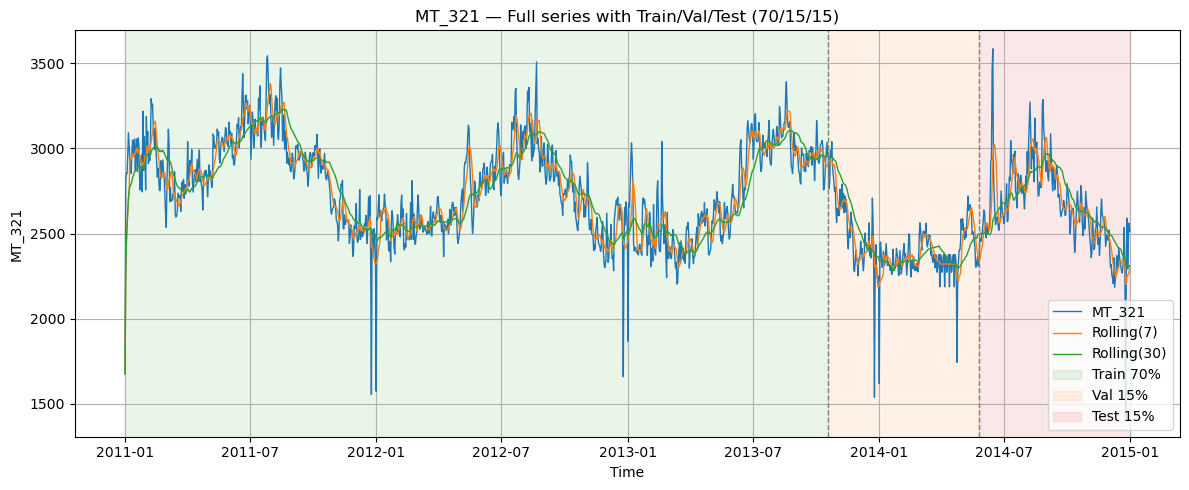

In [81]:
# ===== 70/15/15 plot + split diagnostics for MT_321 =====
s = merged_df['MT_321'].dropna()
idx = s.index
T = len(s)
n_train = int(T*0.70)
n_val   = int(T*0.15)
n_test  = T - n_train - n_val

i_tr0, i_tr1 = 0, n_train-1
i_va0, i_va1 = n_train, n_train+n_val-1
i_te0, i_te1 = n_train+n_val, T-1

def seg(x, a, b): return x[a:b+1]  # inclusive

# --- rolling context ---
roll7  = s.rolling(7,  min_periods=1).mean()
roll30 = s.rolling(30, min_periods=1).mean()

# --- full plot with datetime-aware spans ---
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(idx, s.values, label='MT_321', linewidth=1)
ax.plot(idx, roll7.values,  label='Rolling(7)', linewidth=1)
ax.plot(idx, roll30.values, label='Rolling(30)', linewidth=1)

# shaded spans (use datetime bounds if possible)
ax.axvspan(idx[i_tr0], idx[i_tr1], alpha=0.10, color='tab:green',  label='Train 70%')
ax.axvspan(idx[i_va0], idx[i_va1], alpha=0.10, color='tab:orange', label='Val 15%')
ax.axvspan(idx[i_te0], idx[i_te1], alpha=0.10, color='tab:red',    label='Test 15%')

ax.axvline(idx[i_va0], color='gray', linestyle='--', linewidth=1)
ax.axvline(idx[i_te0], color='gray', linestyle='--', linewidth=1)
ax.set_title("MT_321 — Full series with Train/Val/Test (70/15/15)")
ax.set_xlabel("Time"); ax.set_ylabel("MT_321"); ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()


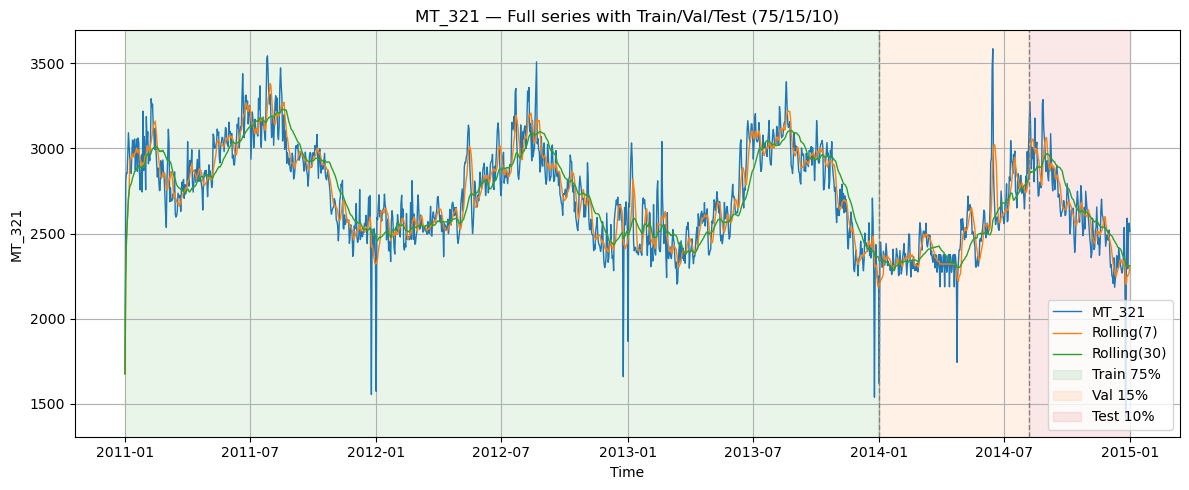

In [83]:
# ===== 70/15/15 plot + split diagnostics for MT_321 =====
s = merged_df['MT_321'].dropna()
idx = s.index
T = len(s)
n_train = int(T*0.75)
n_val   = int(T*0.15)
n_test  = T - n_train - n_val

i_tr0, i_tr1 = 0, n_train-1
i_va0, i_va1 = n_train, n_train+n_val-1
i_te0, i_te1 = n_train+n_val, T-1

def seg(x, a, b): return x[a:b+1]  # inclusive

# --- rolling context ---
roll7  = s.rolling(7,  min_periods=1).mean()
roll30 = s.rolling(30, min_periods=1).mean()

# --- full plot with datetime-aware spans ---
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(idx, s.values, label='MT_321', linewidth=1)
ax.plot(idx, roll7.values,  label='Rolling(7)', linewidth=1)
ax.plot(idx, roll30.values, label='Rolling(30)', linewidth=1)

# shaded spans (use datetime bounds if possible)
ax.axvspan(idx[i_tr0], idx[i_tr1], alpha=0.10, color='tab:green',  label='Train 75%')
ax.axvspan(idx[i_va0], idx[i_va1], alpha=0.10, color='tab:orange', label='Val 15%')
ax.axvspan(idx[i_te0], idx[i_te1], alpha=0.10, color='tab:red',    label='Test 10%')

ax.axvline(idx[i_va0], color='gray', linestyle='--', linewidth=1)
ax.axvline(idx[i_te0], color='gray', linestyle='--', linewidth=1)
ax.set_title("MT_321 — Full series with Train/Val/Test (75/15/10)")
ax.set_xlabel("Time"); ax.set_ylabel("MT_321"); ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()


# LSTM BASELİNE  MODEL

In [91]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from time import time

# ==============================
# 1. Feature Selection
# ==============================
features = ['MT_321', 'Avg_Temperature_C']
data = merged_df[features].copy().dropna().values

# ==============================
# 2. Train/Validation/Test Split (75/15/10)
# ==============================
T = len(data)
n_train = int(T * 0.75)
n_val   = int(T * 0.15)
n_test  = T - n_train - n_val

train_raw = data[:n_train]
val_raw   = data[n_train:n_train+n_val]
test_raw  = data[n_train+n_val:]

# ==============================
# 3. Scaling (fit only on train)
# ==============================
scaler = MinMaxScaler().fit(train_raw)
train_scaled = scaler.transform(train_raw)
val_scaled   = scaler.transform(val_raw)
test_scaled  = scaler.transform(test_raw)

# ==============================
# 4. Sequence Creator
# ==============================
def create_sequences(data, target_column=0, lookback=7):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])
        y.append(data[i, target_column])
    return np.array(X), np.array(y)

lookback = 7
X_train, y_train = create_sequences(train_scaled, target_column=0, lookback=lookback)
X_val, y_val     = create_sequences(val_scaled,   target_column=0, lookback=lookback)
X_test, y_test   = create_sequences(test_scaled,  target_column=0, lookback=lookback)

# ==============================
# 5. Baseline LSTM Model
# ==============================
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# ==============================
# 6. Training
# ==============================
start_time = time()
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=False
)
elapsed_time = time() - start_time

# ==============================
# 7. Evaluation on Test Set (real scale)
# ==============================
y_pred_scaled = model.predict(X_test).flatten()
tmin, tmax = scaler.data_min_[0], scaler.data_max_[0]

# Inverse scaling
y_pred = y_pred_scaled * (tmax - tmin) + tmin
y_true = y_test * (tmax - tmin) + tmin

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"📊 Test RMSE (Baseline LSTM, 75/15/10): {rmse:.2f}")


Epoch 1/100


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3004 - val_loss: 0.0055
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185 - val_loss: 0.0090
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0072
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_l

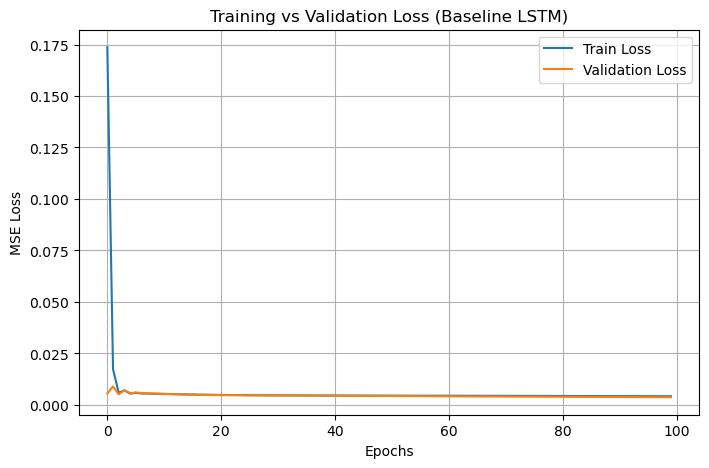

In [94]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss (Baseline LSTM)')
plt.legend()
plt.grid(True)
plt.show()

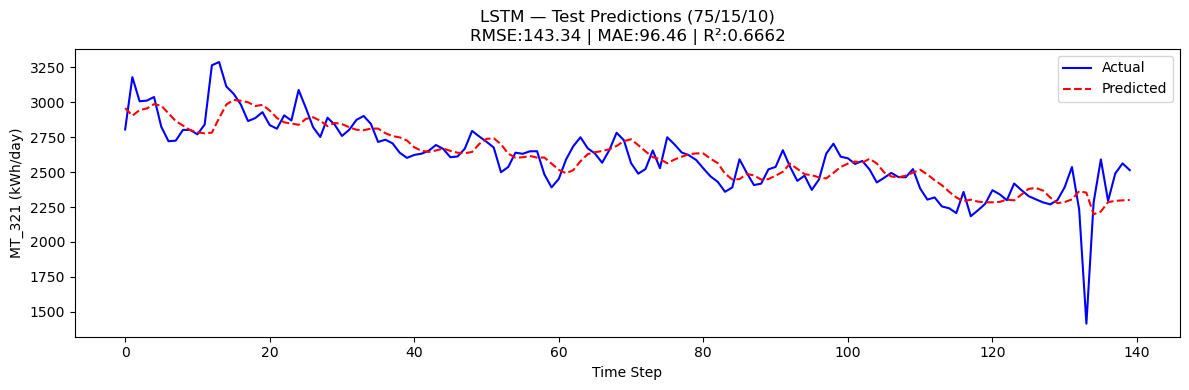

In [100]:
from sklearn.metrics import mean_absolute_error, r2_score


mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)


plt.figure(figsize=(12,4))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title(f"LSTM — Test Predictions (75/15/10)\nRMSE:{rmse:.2f} | MAE:{mae:.2f} | R²:{r2:.4f}")
plt.xlabel("Time Step")
plt.ylabel("MT_321 (kWh/day)")
plt.legend()
plt.tight_layout()
plt.show()


# Traditional Hyperparameter Optimization 

# GrıdSearch for LSTM

In [67]:
# =====  LSTM GridSearch (75/15/10 split) =====
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

features   = ['MT_321', 'Avg_Temperature_C']
target_col = 'MT_321'
target_idx = features.index(target_col)

ACTIVATION = 'tanh'
EPOCHS     = 100
PATIENCE   = 8

LOOKBACKS      = [7, 14, 30]
UNITS_LIST     = [32, 64, 96]
BATCH_SIZES    = [16, 32, 64]
LEARNING_RATES = [1e-4, 5e-4, 1e-3]
WEIGHT_DECAYS  = [1e-6, 1e-5, 1e-4]
DROPOUTS       = [0.0]  

def temporal_split_idx_3(n, r_train=0.75, r_val=0.15):
    n_train = int(n*r_train)
    n_val   = int(n*r_val)
    n_test  = n - n_train - n_val
    return n_train, n_val, n_test

def create_sequences_from_array(arr2d, lookback, target_col_idx):
    X, y = [], []
    for i in range(len(arr2d) - lookback):
        X.append(arr2d[i:i+lookback, :])
        y.append(arr2d[i+lookback, target_col_idx])
    return np.array(X), np.array(y)

def lstm_gridsearch_train_val(merged_df):
    data = merged_df[features].dropna().copy()
    T = len(data)
    n_train, n_val, n_test = temporal_split_idx_3(T, 0.75, 0.15)

    train_df = data.iloc[:n_train]
    val_df   = data.iloc[n_train:n_train+n_val]

    scaler = MinMaxScaler().fit(train_df.values)
    train_s = scaler.transform(train_df.values)
    val_s   = scaler.transform(val_df.values)

    tmin = scaler.data_min_[target_idx]; tmax = scaler.data_max_[target_idx]

    best_cfg, best_rmse = {}, float('inf')
    results = []
    total = (len(LOOKBACKS)*len(UNITS_LIST)*len(BATCH_SIZES)*
             len(LEARNING_RATES)*len(WEIGHT_DECAYS)*len(DROPOUTS))
    print(f"[GRID-LSTM] rows={T} | train={n_train} val={n_val} test={n_test} | combos={total}")

    for lookback in LOOKBACKS:
        Xtr, ytr = create_sequences_from_array(train_s, lookback, target_idx)
        Xva, yva = create_sequences_from_array(val_s,   lookback, target_idx)
        if len(Xtr)==0 or len(Xva)==0: 
            continue

        for units in UNITS_LIST:
            for bs in BATCH_SIZES:
                for lr in LEARNING_RATES:
                    for wd in WEIGHT_DECAYS:
                        for do in DROPOUTS:
                            try:
                                model = Sequential([
                                    LSTM(units, activation=ACTIVATION, dropout=do,
                                         input_shape=(lookback, len(features))),
                                    Dense(1)
                                ])
                                opt = Adam(learning_rate=lr, weight_decay=wd, clipnorm=1.0)
                                model.compile(optimizer=opt, loss='mse')
                                cb  = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                                                    restore_best_weights=True, verbose=0)

                                _ = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                                              epochs=EPOCHS, batch_size=bs, shuffle=False,
                                              verbose=0, callbacks=[cb])

                                yv_pred = model.predict(Xva, verbose=0).flatten()
                                yv_inv      = yva*(tmax-tmin)+tmin
                                yv_pred_inv = yv_pred*(tmax-tmin)+tmin

                                rmse = float(np.sqrt(mean_squared_error(yv_inv, yv_pred_inv)))
                                mae  = float(mean_absolute_error(yv_inv, yv_pred_inv))
                                r2   = float(r2_score(yv_inv, yv_pred_inv))

                                results.append({'lookback':lookback,'units':units,'batch_size':bs,
                                                'learning_rate':lr,'weight_decay':wd,'dropout':do,
                                                'val_rmse_real':rmse,'val_mae_real':mae,'val_r2':r2})
                                if rmse < best_rmse:
                                    best_rmse = rmse
                                    best_cfg = {'lookback':lookback,'units':units,'batch_size':bs,
                                                'learning_rate':lr,'weight_decay':wd,'dropout':do}
                            except tf.errors.ResourceExhaustedError:
                                print("⚠️ Skipped (OOM):", lookback, units, bs, lr, wd, do)
                            finally:
                                del model
                                K.clear_session()
                                gc.collect()

    df = (pd.DataFrame(results).sort_values('val_rmse_real').reset_index(drop=True)
          if results else pd.DataFrame())
    print("\n[A BLOK] Top-5:")
    print(df.head(5))
    print("\n[A BLOK] Best config:", best_cfg)
    return df, best_cfg


lstm_results_df, lstm_best_cfg = lstm_gridsearch_train_val(merged_df)


[GRID-LSTM] rows=1461 | train=1095 val=219 test=147 | combos=243



[A BLOK] Top-5:
   lookback  units  batch_size  learning_rate  weight_decay  dropout  \
0        14     64          32         0.0010      0.000100      0.0   
1        14     96          32         0.0010      0.000001      0.0   
2        14     64          32         0.0010      0.000010      0.0   
3        14     96          32         0.0005      0.000100      0.0   
4        14     96          32         0.0010      0.000010      0.0   

   val_rmse_real  val_mae_real    val_r2  
0     108.615533     75.083925  0.766491  
1     109.349220     76.204749  0.763326  
2     109.678516     76.521172  0.761898  
3     109.684268     75.247635  0.761873  
4     110.906912     77.667032  0.756535  

[A BLOK] Best config: {'lookback': 14, 'units': 64, 'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'dropout': 0.0}


# Performance Evaluation of the LSTM Model with Optimal Hyperparameters Identified via Grid Search

[LSTM TEST @75/15/10] RMSE:128.76  MAE:81.05  R²:0.7112


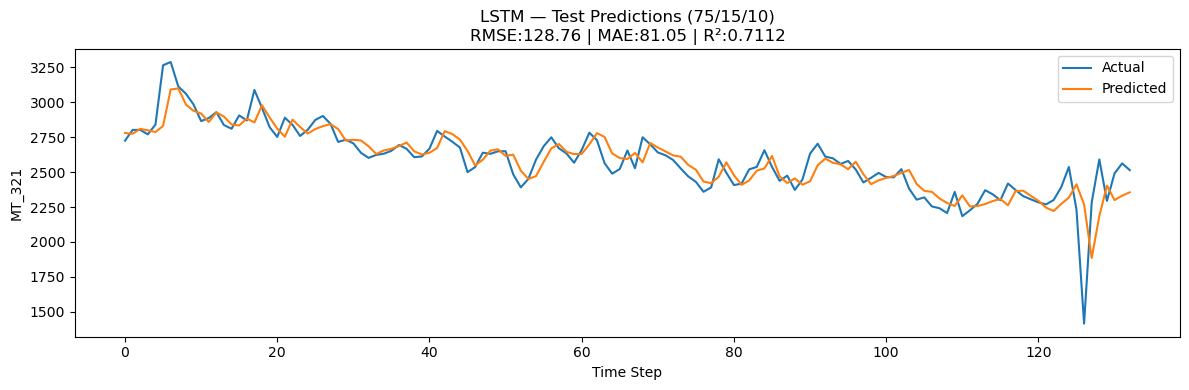

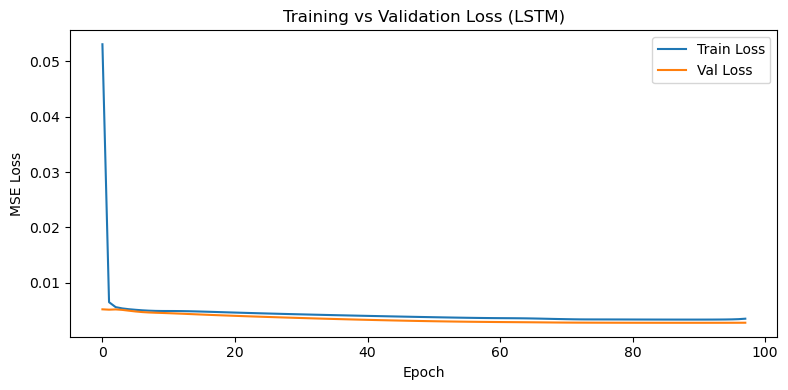

In [75]:
def lstm_eval_on_test_75(merged_df, best_cfg):
    features = ['MT_321','Avg_Temperature_C']
    target_idx = 0
    data = merged_df[features].dropna().values

    # ---- 75/15/10 ----
    T = len(data)
    n_train, n_val = int(T*0.75), int(T*0.15)
    train_raw = data[:n_train]
    val_raw   = data[n_train:n_train+n_val]
    test_raw  = data[n_train+n_val:]

    
    scaler = MinMaxScaler().fit(train_raw)
    train = scaler.transform(train_raw)
    val   = scaler.transform(val_raw)
    test  = scaler.transform(test_raw)

    tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

    def seq(a, L):
        X, y = [], []
        for i in range(L, len(a)):
            X.append(a[i-L:i, :])
            y.append(a[i, target_idx])
        return np.array(X), np.array(y)

    L = best_cfg['lookback']
    Xtr, ytr = seq(train, L)
    Xva, yva = seq(val,   L)
    Xte, yte = seq(test,  L)

    # ---- Model ----
    model = Sequential([
        Input(shape=(L, len(features))),
        LSTM(best_cfg['units'], activation='tanh', dropout=best_cfg.get('dropout', 0.0)),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=best_cfg['learning_rate'],
                       weight_decay=best_cfg['weight_decay'],
                       clipnorm=1.0),
        loss='mse'
    )

    # ---- Training (EarlyStopping ile) ----
    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    history = model.fit(
        np.concatenate([Xtr, Xva]), np.concatenate([ytr, yva]),
        validation_data=(Xva, yva),
        epochs=100, batch_size=best_cfg['batch_size'],
        shuffle=False, verbose=0, callbacks=[es]
    )

    # ---- Predictions & metrics (real scale) ----
    y_pred = model.predict(Xte, verbose=0).flatten()
    y_true = yte * (tmax - tmin) + tmin
    y_hat  = y_pred * (tmax - tmin) + tmin

    rmse = float(np.sqrt(mean_squared_error(y_true, y_hat)))
    mae  = float(mean_absolute_error(y_true, y_hat))
    r2   = float(r2_score(y_true, y_hat))
    print(f"[LSTM TEST @75/15/10] RMSE:{rmse:.2f}  MAE:{mae:.2f}  R²:{r2:.4f}")

    # ---- Graph 1
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label='Actual')
    plt.plot(y_hat,  label='Predicted')
    plt.title(f"LSTM — Test Predictions (75/15/10)\nRMSE:{rmse:.2f} | MAE:{mae:.2f} | R²:{r2:.4f}")
    plt.xlabel("Time Step"); plt.ylabel("MT_321"); plt.legend()
    plt.tight_layout(); plt.show()

    # ---- Graph 2 Train vs Val Loss ----
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training vs Validation Loss (LSTM)")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
    plt.tight_layout(); plt.show()

    return {'rmse':rmse,'mae':mae,'r2':r2}

# ---- Best config----
lstm_best_cfg = {
    'lookback': 14,
    'units': 64,
    'batch_size': 32,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'dropout': 0.0
}


lstm_final_metrics = lstm_eval_on_test_75(merged_df, lstm_best_cfg)


 # RandomSearch 

In [77]:
# ===== LSTM RandomSearch (75/15/10 split, 100 iteration) =====
#------------------ 1. Reproducibility ------------------
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ------------------ 2. Hyperparameter Space ------------------
LOOKBACKS      = [7, 10, 14, 30]
UNITS_LIST     = [32, 64, 96]
BATCH_SIZES    = [16, 32, 64]
LEARNING_RATES = [1e-4, 5e-4, 1e-3]
WEIGHT_DECAYS  = [1e-6, 1e-5, 1e-4]
DROPOUTS       = [0.0]   # fixed

ACTIVATION     = 'tanh'
EPOCHS         = 100
PATIENCE       = 8
N_ITERATIONS   = 100   

features   = ['MT_321', 'Avg_Temperature_C']
target_col = 'MT_321'
target_idx = features.index(target_col)

# ------------------ 3. Sequence function ------------------
def create_sequences_from_array(arr2d, lookback, target_col_idx):
    X, y = [], []
    for i in range(len(arr2d) - lookback):
        X.append(arr2d[i:i+lookback, :])
        y.append(arr2d[i+lookback, target_col_idx])
    return np.array(X), np.array(y)

# ------------------ 4. Temporal Split (75/15/10) ------------------
def temporal_split_idx_3(n, r_train=0.75, r_val=0.15):
    n_train = int(n*r_train)
    n_val   = int(n*r_val)
    n_test  = n - n_train - n_val
    return n_train, n_val, n_test

# ------------------ 5. Random Search ------------------
def lstm_randomsearch_train_val(merged_df, n_iter=N_ITERATIONS):
    data = merged_df[features].dropna().copy()
    T = len(data)
    n_train, n_val, n_test = temporal_split_idx_3(T, 0.75, 0.15)

    train_df = data.iloc[:n_train]
    val_df   = data.iloc[n_train:n_train+n_val]

    scaler = MinMaxScaler().fit(train_df.values)
    train_s = scaler.transform(train_df.values)
    val_s   = scaler.transform(val_df.values)

    tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

    results, best_cfg, best_rmse = [], {}, float('inf')
    print(f"[RANDOM-LSTM] rows={T} | train={n_train} val={n_val} test={n_test} | iterations={n_iter}")

    for it in range(n_iter):
        # --- Random HP  ---
        lookback = random.choice(LOOKBACKS)
        units    = random.choice(UNITS_LIST)
        bs       = random.choice(BATCH_SIZES)
        lr       = random.choice(LEARNING_RATES)
        wd       = random.choice(WEIGHT_DECAYS)
        do       = random.choice(DROPOUTS)

        # --- Sequence  ---
        Xtr,ytr = create_sequences_from_array(train_s, lookback, target_idx)
        Xva,yva = create_sequences_from_array(val_s,   lookback, target_idx)
        if len(Xtr)==0 or len(Xva)==0:
            continue

        try:
            # --- Model  ---
            model = Sequential([
                LSTM(units, activation=ACTIVATION, dropout=do,
                     input_shape=(lookback, len(features))),
                Dense(1)
            ])
            opt = Adam(learning_rate=lr, weight_decay=wd, clipnorm=1.0)
            model.compile(optimizer=opt, loss='mse')
            cb  = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                                restore_best_weights=True, verbose=0)

            # --- Train ---
            _ = model.fit(Xtr, ytr, validation_data=(Xva,yva),
                          epochs=EPOCHS, batch_size=bs, shuffle=False,
                          verbose=0, callbacks=[cb])

            # --- Predict & inverse scale ---
            yv_pred = model.predict(Xva, verbose=0).flatten()
            yv_inv      = yva*(tmax-tmin)+tmin
            yv_pred_inv = yv_pred*(tmax-tmin)+tmin

            rmse = float(np.sqrt(mean_squared_error(yv_inv, yv_pred_inv)))
            mae  = float(mean_absolute_error(yv_inv, yv_pred_inv))
            r2   = float(r2_score(yv_inv, yv_pred_inv))

            results.append({'lookback':lookback,'units':units,'batch_size':bs,
                            'learning_rate':lr,'weight_decay':wd,'dropout':do,
                            'val_rmse_real':rmse,'val_mae_real':mae,'val_r2':r2})

            if rmse < best_rmse:
                best_rmse = rmse
                best_cfg = {'lookback':lookback,'units':units,'batch_size':bs,
                            'learning_rate':lr,'weight_decay':wd,'dropout':do}

        except tf.errors.ResourceExhaustedError:
            print("⚠️ Skipped (OOM):", lookback, units, bs, lr, wd, do)
        finally:
            del model
            K.clear_session()
            gc.collect()

    df = (pd.DataFrame(results).sort_values('val_rmse_real').reset_index(drop=True)
          if results else pd.DataFrame())
    print("\n[RANDOM BLOK] Top-5:")
    print(df.head(5))
    print("\n[RANDOM BLOK] Best config:", best_cfg)
    return df, best_cfg



lstm_rand_results_df, lstm_rand_best_cfg = lstm_randomsearch_train_val(merged_df, n_iter=100)


[RANDOM-LSTM] rows=1461 | train=1095 val=219 test=147 | iterations=100



[RANDOM BLOK] Top-5:
   lookback  units  batch_size  learning_rate  weight_decay  dropout  \
0        10     96          32          0.001      0.000100      0.0   
1         7     64          32          0.001      0.000010      0.0   
2        14     96          64          0.001      0.000001      0.0   
3        14     96          32          0.001      0.000001      0.0   
4        14     96          32          0.001      0.000001      0.0   

   val_rmse_real  val_mae_real    val_r2  
0     108.091288     74.664650  0.765823  
1     108.161008     73.840565  0.763641  
2     108.895290     74.824549  0.765287  
3     109.111152     75.868686  0.764355  
4     110.491643     77.447195  0.758355  

[RANDOM BLOK] Best config: {'lookback': 10, 'units': 96, 'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'dropout': 0.0}


# Performance  of LSTM model wıth optımal hyperamaters from RandomSearch

Epoch 1/100


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1579 - val_loss: 0.0090
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131 - val_loss: 0.0056
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_l

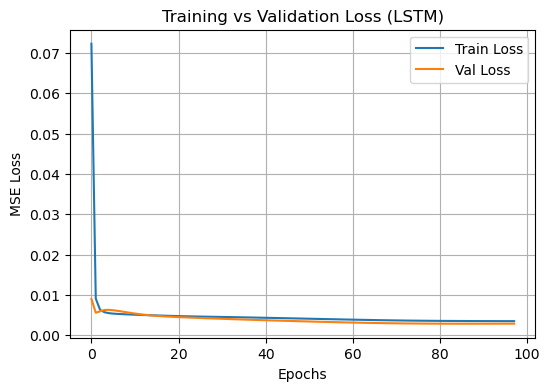

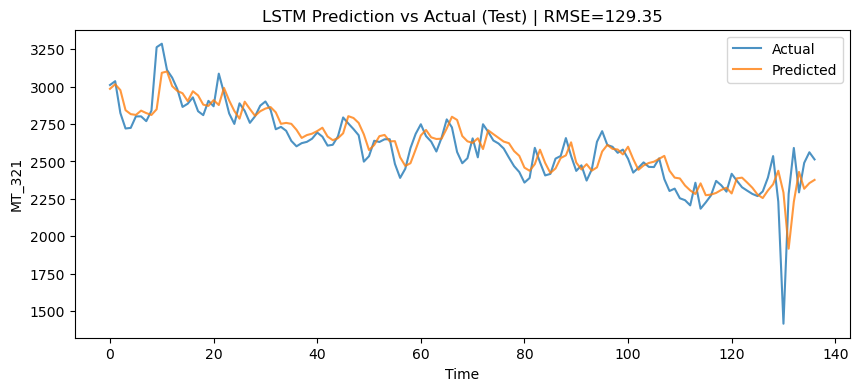

In [79]:
# ==== Final LSTM Model (best config from RandomSearch) ====
import matplotlib.pyplot as plt

best_cfg = {'lookback': 10, 'units': 96, 'batch_size': 32,
            'learning_rate': 0.001, 'weight_decay': 0.0001, 'dropout': 0.0}

# --- Split data (75/15/10) ---
data = merged_df[features].dropna().copy()
T = len(data)
n_train = int(T*0.75)
n_val   = int(T*0.15)
n_test  = T - n_train - n_val

train_df = data.iloc[:n_train]
val_df   = data.iloc[n_train:n_train+n_val]
test_df  = data.iloc[n_train+n_val:]

scaler = MinMaxScaler().fit(train_df.values)
train_s = scaler.transform(train_df.values)
val_s   = scaler.transform(val_df.values)
test_s  = scaler.transform(test_df.values)

tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

# --- Sequence creation ---
def create_sequences_from_array(arr2d, lookback, target_col_idx):
    X, y = [], []
    for i in range(len(arr2d) - lookback):
        X.append(arr2d[i:i+lookback, :])
        y.append(arr2d[i+lookback, target_col_idx])
    return np.array(X), np.array(y)

lookback = best_cfg['lookback']
Xtr,ytr = create_sequences_from_array(train_s, lookback, target_idx)
Xva,yva = create_sequences_from_array(val_s,   lookback, target_idx)
Xte,yte = create_sequences_from_array(test_s,  lookback, target_idx)

# --- Model ---
model = Sequential([
    LSTM(best_cfg['units'], activation='tanh', dropout=best_cfg['dropout'],
         input_shape=(lookback, len(features))),
    Dense(1)
])
opt = Adam(learning_rate=best_cfg['learning_rate'], 
           weight_decay=best_cfg['weight_decay'], clipnorm=1.0)
model.compile(optimizer=opt, loss='mse')

cb  = EarlyStopping(monitor='val_loss', patience=10,
                    restore_best_weights=True, verbose=1)

history = model.fit(Xtr, ytr, validation_data=(Xva,yva),
                    epochs=100, batch_size=best_cfg['batch_size'],
                    shuffle=False, callbacks=[cb], verbose=1)

# --- Predict ---
yte_pred = model.predict(Xte).flatten()
yte_inv      = yte*(tmax-tmin)+tmin
yte_pred_inv = yte_pred*(tmax-tmin)+tmin

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(yte_inv, yte_pred_inv))
mae  = mean_absolute_error(yte_inv, yte_pred_inv)
r2   = r2_score(yte_inv, yte_pred_inv)

print(f"\n✅ Test RMSE: {rmse:.2f}")
print(f"✅ Test MAE : {mae:.2f}")
print(f"✅ Test R²  : {r2:.3f}")

# --- Plot: Loss curves ---
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss (LSTM)')
plt.legend(); plt.grid(True); plt.show()

# --- Plot: Predictions vs Actual ---
plt.figure(figsize=(10,4))
plt.plot(yte_inv, label="Actual", alpha=0.8)
plt.plot(yte_pred_inv, label="Predicted", alpha=0.8)
plt.title(f"LSTM Prediction vs Actual (Test) | RMSE={rmse:.2f}")
plt.xlabel("Time"); plt.ylabel("MT_321")
plt.legend(); plt.show()

# KerasTuner BayesianOptimization Optimization

In [89]:
# ===== LSTM + KerasTuner (Bayesian) — 75/15/10 =====

# ---------------- 0) Reproducibility ----------------
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ---------------- 1) Data & Split (75/15/10) ----------------
features = ['MT_321', 'Avg_Temperature_C']
df = merged_df[features].dropna().copy().values

T = len(df)
n_train = int(T*0.75)
n_val   = int(T*0.15)
n_test  = T - n_train - n_val  # %10

train_raw = df[:n_train]
val_raw   = df[n_train:n_train+n_val]
test_raw  = df[n_train+n_val:]  


scaler = MinMaxScaler().fit(train_raw)
train_s = scaler.transform(train_raw)
val_s   = scaler.transform(val_raw)
target_idx = 0
tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]
n_features = train_s.shape[1]

# ---------------- 2) Sequence helper ----------------
def make_seq(a, L, target_col_idx=0):
    X, y = [], []
    for i in range(L, len(a)):
        X.append(a[i-L:i, :]); y.append(a[i, target_col_idx])
    return np.array(X), np.array(y)

# ---------------- 3) HP Space ----------------
LOOKBACKS      = [7, 10, 14, 30]
UNITS_LIST     = [32, 64, 96]
BATCH_SIZES    = [16, 32, 64]
LEARNING_RATES = [1e-4, 5e-4, 1e-3]
WEIGHT_DECAYS  = [1e-6, 1e-5, 1e-4]
DROPOUT_FIXED  = 0.0
EPOCHS, PATIENCE = 100, 10

# ---------------- 4) Model builder (AdamW, dropout=0.0) ----------------
def build_model(hp):
    units         = hp.Choice('units',         UNITS_LIST)
    learning_rate = hp.Choice('learning_rate', LEARNING_RATES)
    weight_decay  = hp.Choice('weight_decay',  WEIGHT_DECAYS)

    model = Sequential([
        Input(shape=(None, n_features)),
        LSTM(units, activation='tanh', dropout=DROPOUT_FIXED),
        Dense(1)
    ])
    opt = Adam(learning_rate=learning_rate, weight_decay=weight_decay, clipnorm=1.0)
    model.compile(optimizer=opt, loss='mse')
    return model

# ---------------- 5) Custom Bayesian Tuner ----------------
training_times = {}

class LookbackTuner(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        hp         = trial.hyperparameters
        lookback   = hp.Choice('lookback',   LOOKBACKS)
        batch_size = hp.Choice('batch_size', BATCH_SIZES)

        Xtr, ytr = make_seq(train_s, lookback, target_idx)
        Xva, yva = make_seq(val_s,   lookback, target_idx)
        if len(Xtr)==0 or len(Xva)==0:
            return float('inf')

        model = self.hypermodel.build(hp)

        # Callbacks
        ckpt_path = os.path.join(self.directory, self.project_name, f"trial_{trial.trial_id}", "ckpt.weights.h5")
        os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
        cb_ckpt = ModelCheckpoint(ckpt_path, save_weights_only=True, save_best_only=True,
                                  monitor='val_loss', mode='min', verbose=0)
        cb_es   = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                                restore_best_weights=True, verbose=0)

        # Train + time counter
        t0 = time.time()
        model.fit(Xtr, ytr,
                  validation_data=(Xva, yva),
                  epochs=EPOCHS, batch_size=batch_size,
                  shuffle=False, verbose=0,
                  callbacks=[cb_ckpt, cb_es])
        training_times[trial.trial_id] = time.time() - t0

        # Val RMSE (real scale) — objective
        y_pred = model.predict(Xva, verbose=0).flatten()
        y_true_inv = yva*(tmax - tmin) + tmin
        y_pred_inv = y_pred*(tmax - tmin) + tmin
        val_rmse = float(np.sqrt(mean_squared_error(y_true_inv, y_pred_inv)))

        
        del model, Xtr, ytr, Xva, yva, y_pred
        K.clear_session(); gc.collect()

        return val_rmse

# ---------------- 6) Tuner init & search (Total elapsed time include) ----------------
tuner_dir = os.path.join(os.path.expanduser("~"), "Desktop", "lstm_tuner_bayes_75_15_10")
shutil.rmtree(tuner_dir, ignore_errors=True)

tuner = LookbackTuner(
    hypermodel=build_model,
    objective=kt.Objective("val_rmse", direction="min"),  # run_trial return 
    max_trials=100,  
    executions_per_trial=1,
    overwrite=True,
    directory=tuner_dir,
    project_name="lstm_bayesian"
)

total_start = time.time()
tuner.search(epochs=EPOCHS, verbose=1)
total_elapsed = time.time() - total_start

# ---------------- 7) Best result & report ----------------
best_hp    = tuner.get_best_hyperparameters(1)[0]
best_trial = tuner.oracle.get_best_trials(1)[0]

def fmt_hms(sec):
    h = int(sec//3600); m = int((sec%3600)//60); s = int(sec%60)
    return f"{h:02d}h {m:02d}m {s:02d}s"

print("\n✅ Best Hyperparameters (LSTM Bayesian, 75/15/10):")
for p in ['lookback','units','batch_size','learning_rate','weight_decay']:
    print(f"{p}: {best_hp.get(p)}")
print(f"\n✅ Validation RMSE (real scale): {best_trial.score:.2f}")
print(f"⏱ Training time (best trial {best_trial.trial_id}): {training_times.get(best_trial.trial_id, float('nan')):.2f} s")
print(f"⏱ Total elapsed time: {fmt_hms(total_elapsed)}")


Trial 100 Complete [00h 00m 36s]
val_rmse: 107.46081683745045

Best val_rmse So Far: 107.14975651369498
Total elapsed time: 00h 51m 39s

✅ Best Hyperparameters (LSTM Bayesian, 75/15/10):
lookback: 10
units: 64
batch_size: 32
learning_rate: 0.001
weight_decay: 0.0001

✅ Validation RMSE (real scale): 107.15
⏱ Training time (best trial 028): 26.25 s
⏱ Total elapsed time: 00h 51m 38s


#  Performance  of LSTM model wıth optımal hyperamaters from Kerastuner


📊 LSTM — FINAL on TEST (75/15/10)
RMSE: 127.46
MAE : 80.26
R²  : 0.7245


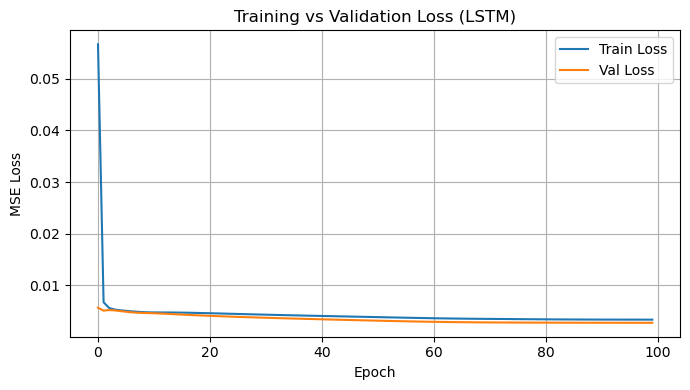

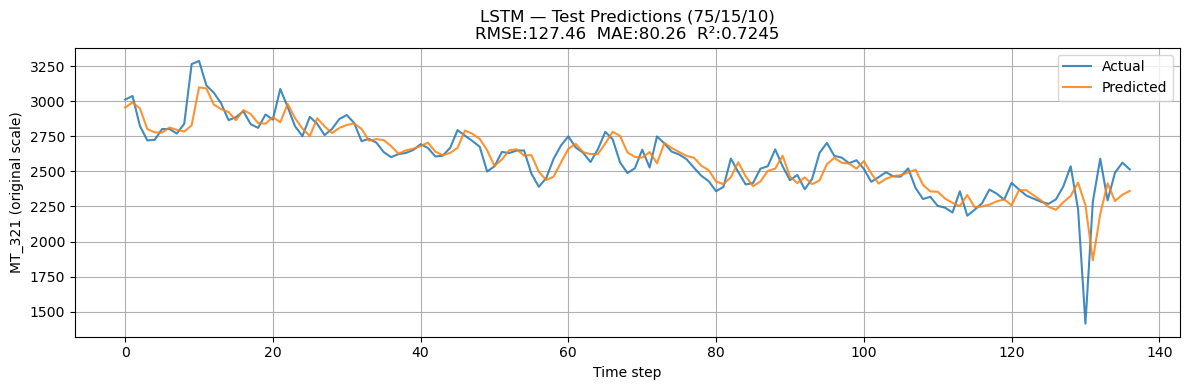

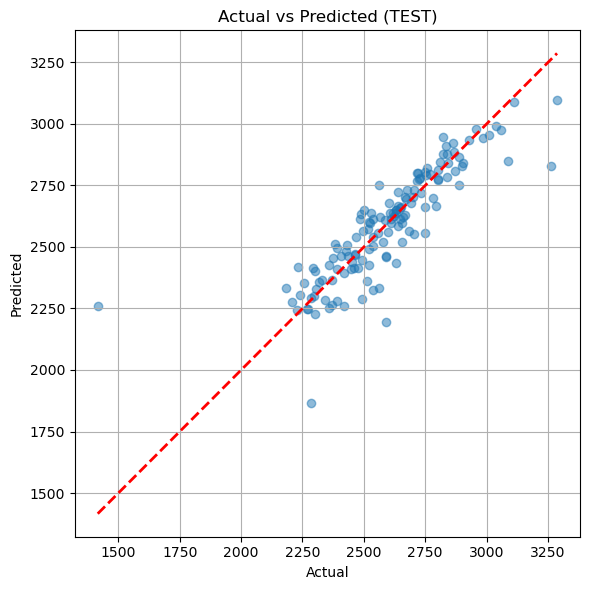

In [110]:
# ===== LSTM — Final Evaluation on TEST (75/15/10) | Best HP (Bayesian) =====


# --- Best HP (Bayesian, 75/15/10) ---
best_cfg = {
    'lookback': 10,
    'units': 64,
    'batch_size': 32,
    'learning_rate': 0.001,
    'weight_decay': 0.0001
}


test_s = scaler.transform(test_raw)


L = best_cfg['lookback']
Xtr, ytr = make_seq(train_s, L, target_idx)
Xva, yva = make_seq(val_s,   L, target_idx)
Xte, yte = make_seq(test_s,  L, target_idx)

# --- Model ---
model = Sequential([
    Input(shape=(L, n_features)),
    LSTM(best_cfg['units'], activation='tanh', dropout=0.0),
    Dense(1)
])
opt = Adam(learning_rate=best_cfg['learning_rate'],
           weight_decay=best_cfg['weight_decay'],
           clipnorm=1.0)
model.compile(optimizer=opt, loss='mse')


es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
history = model.fit(
    np.concatenate([Xtr, Xva]), np.concatenate([ytr, yva]),
    validation_data=(Xva, yva),
    epochs=100, batch_size=best_cfg['batch_size'],
    shuffle=False, verbose=0, callbacks=[es]
)


y_pred_te = model.predict(Xte, verbose=0).flatten()

# --- Inverse-scale (real-scale) ---
y_true_te = yte * (tmax - tmin) + tmin
y_hat_te  = y_pred_te * (tmax - tmin) + tmin

# --- Metrikler ---
rmse = float(np.sqrt(mean_squared_error(y_true_te, y_hat_te)))
mae  = float(mean_absolute_error(y_true_te, y_hat_te))
r2   = float(r2_score(y_true_te, y_hat_te))

print("\n📊 LSTM — FINAL on TEST (75/15/10)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


SHOW_PLOTS = True
if SHOW_PLOTS:
    # (1) Train vs Validation Loss 
    plt.figure(figsize=(7,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training vs Validation Loss (LSTM)")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # Real and Prediction
    plt.figure(figsize=(12,4))
    plt.plot(y_true_te, label="Actual", alpha=0.85)
    plt.plot(y_hat_te,  label="Predicted", alpha=0.85)
    plt.title(f"LSTM — Test Predictions (75/15/10)\nRMSE:{rmse:.2f}  MAE:{mae:.2f}  R²:{r2:.4f}")
    plt.xlabel("Time step"); plt.ylabel("MT_321 (original scale)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # (3) Scatter: Actual vs Predicted (TEST)
    plt.figure(figsize=(6,6))
    plt.scatter(y_true_te, y_hat_te, alpha=0.5)
    lims = [min(y_true_te.min(), y_hat_te.min()), max(y_true_te.max(), y_hat_te.max())]
    plt.plot(lims, lims, 'r--', lw=2)
    plt.title("Actual vs Predicted (TEST)")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.grid(True); plt.tight_layout(); plt.show()


# Optuna Tunning for LSTM MODEL

In [77]:
import time
import os, gc, random
# ===== LSTM + Optuna (75/15/10,)=====
# ------------------------ 0) Reproducibility ------------------------
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ------------------------ 1) Data & Split (75/15/10) ------------------------
features = ['MT_321', 'Avg_Temperature_C']
df = merged_df[features].dropna().copy().values
n_features = df.shape[1]

T = len(df)
n_train = int(T*0.75)
n_val   = int(T*0.15)
n_test  = T - n_train - n_val   

train_raw = df[:n_train]
val_raw   = df[n_train:n_train+n_val]
test_raw  = df[n_train+n_val:]  


scaler = MinMaxScaler().fit(train_raw)
train_s = scaler.transform(train_raw)
val_s   = scaler.transform(val_raw)
target_idx = 0
tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

# ------------------------ 2) Sequence helper ------------------------
def make_seq(a, L, target_col_idx=0):
    X, y = [], []
    for i in range(L, len(a)):
        X.append(a[i-L:i, :]); y.append(a[i, target_col_idx])
    return np.array(X), np.array(y)

# ------------------------ 3) HP Space------------------------
LOOKBACKS      = [7, 10, 14, 30]
UNITS_LIST     = [32, 64, 96]
BATCH_SIZES    = [16, 32, 64]
LEARNING_RATES = [1e-4, 5e-4, 1e-3]
WEIGHT_DECAYS  = [1e-6, 1e-5, 1e-4]
ACTIVATION     = 'tanh'
DROPOUT_FIXED  = 0.0
EPOCHS         = 100
PATIENCE       = 8

# ------------------------ 4) Optuna Objective ------------------------
training_times = {}  # trial.number -> seconds

def objective(trial):
    lookback      = trial.suggest_categorical("lookback",      LOOKBACKS)
    units         = trial.suggest_categorical("units",         UNITS_LIST)
    batch_size    = trial.suggest_categorical("batch_size",    BATCH_SIZES)
    learning_rate = trial.suggest_categorical("learning_rate", LEARNING_RATES)
    weight_decay  = trial.suggest_categorical("weight_decay",  WEIGHT_DECAYS)

    # Sequences
    Xtr, ytr = make_seq(train_s, lookback, target_idx)
    Xva, yva = make_seq(val_s,   lookback, target_idx)
    if len(Xtr)==0 or len(Xva)==0:
        return float("inf")

    # Model
    model = Sequential([
        Input(shape=(lookback, n_features)),
        LSTM(units, activation=ACTIVATION, dropout=DROPOUT_FIXED),
        Dense(1)
    ])
    opt = Adam(learning_rate=learning_rate, weight_decay=weight_decay, clipnorm=1.0)
    model.compile(optimizer=opt, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)

    # Train with timing
    t0 = time.time()
    _ = model.fit(Xtr, ytr,
                  validation_data=(Xva, yva),
                  epochs=EPOCHS, batch_size=batch_size,
                  shuffle=False, verbose=0, callbacks=[es])
    training_times[trial.number] = time.time() - t0

    # Validation RMSE (real scale)
    y_pred = model.predict(Xva, verbose=0).flatten()
    y_true_inv = yva*(tmax - tmin) + tmin
    y_pred_inv = y_pred*(tmax - tmin) + tmin
    rmse = float(np.sqrt(mean_squared_error(y_true_inv, y_pred_inv)))

    
    del model, Xtr, ytr, Xva, yva, y_pred
    K.clear_session(); gc.collect()

    return rmse

# ------------------------ 5) Run Study (100 trials) ------------------------
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)

total_start = time.time()
study.optimize(objective, n_trials=100, show_progress_bar=False)
total_elapsed = time.time() - total_start

# ------------------------ 6) Results ------------------------
def fmt_hms(sec):
    h = int(sec//3600); m = int((sec%3600)//60); s = int(sec%60)
    return f"{h:02d}h {m:02d}m {s:02d}s"

best_trial = study.best_trial
print("\n🎯 Best LSTM Trial (75/15/10):")
print(f"Validation RMSE (real scale): {best_trial.value:.2f}")
for k, v in best_trial.params.items():
    print(f"{k}: {v}")
print(f"⏱ Training time (best trial {best_trial.number}): {training_times.get(best_trial.number, float('nan')):.2f} s")
print(f"⏱ Total elapsed time: {fmt_hms(total_elapsed)}")

[I 2025-08-22 21:13:40,525] A new study created in memory with name: no-name-abc41aae-a5ef-4356-a59c-ba2b64fd93bf
[I 2025-08-22 21:13:50,389] Trial 0 finished with value: 150.51524387689398 and parameters: {'lookback': 10, 'units': 32, 'batch_size': 16, 'learning_rate': 0.0005, 'weight_decay': 1e-06}. Best is trial 0 with value: 150.51524387689398.
[I 2025-08-22 21:13:58,301] Trial 1 finished with value: 160.0395837801377 and parameters: {'lookback': 10, 'units': 32, 'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 150.51524387689398.
[I 2025-08-22 21:14:07,852] Trial 2 finished with value: 154.46580518469824 and parameters: {'lookback': 14, 'units': 96, 'batch_size': 64, 'learning_rate': 0.0005, 'weight_decay': 1e-06}. Best is trial 0 with value: 150.51524387689398.
[I 2025-08-22 21:14:17,890] Trial 3 finished with value: 150.8344126732483 and parameters: {'lookback': 14, 'units': 32, 'batch_size': 16, 'learning_rate': 0.001, 'weight_decay'


🎯 Best LSTM Trial (75/15/10):
Validation RMSE (real scale): 107.57
lookback: 14
units: 96
batch_size: 64
learning_rate: 0.001
weight_decay: 0.0001
⏱ Training time (best trial 53): 25.31 s
⏱ Total elapsed time: 00h 37m 37s


# LSTM AND BEST HYPERAMETER WİTH OPTUNA


📊 LSTM — FINAL on TEST (75/15/10)
RMSE: 130.41
MAE : 82.59
R²  : 0.7038


<Figure size 700x400 with 0 Axes>

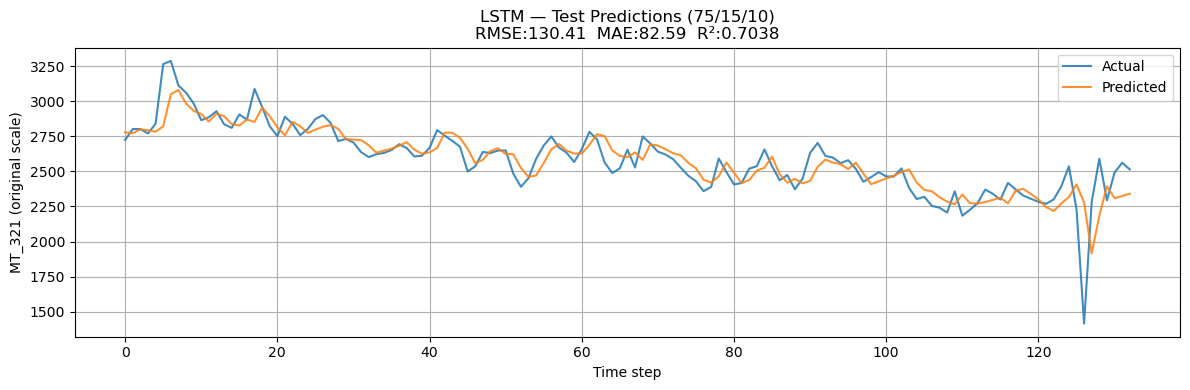

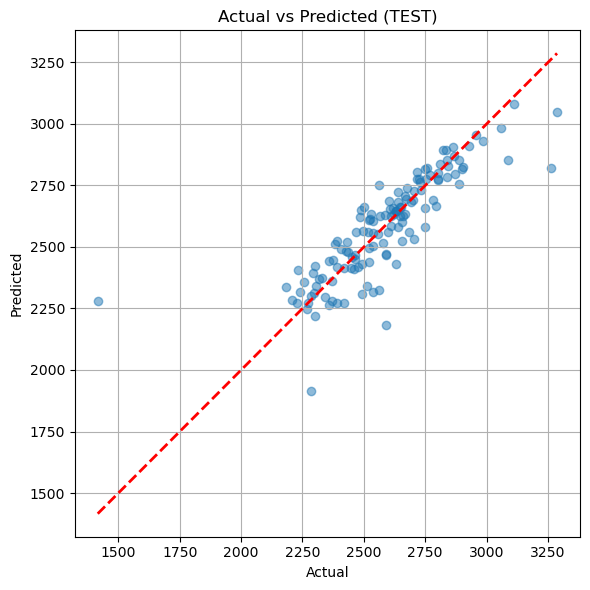

In [87]:
# ===== LSTM — Final Evaluation on TEST (75/15/10) with Optuna best HP =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# --- Best HP ---
best_cfg = {
    'lookback': 14,
    'units': 96,
    'batch_size': 64,
    'learning_rate': 0.001,
    'weight_decay': 0.0001
}

# --- Test scaler---
test_s = scaler.transform(test_raw)


L = best_cfg['lookback']
Xtr, ytr = make_seq(train_s, L, target_idx)
Xva, yva = make_seq(val_s,   L, target_idx)
Xte, yte = make_seq(test_s,  L, target_idx)

# --- Model ---
model = Sequential([
    Input(shape=(L, n_features)),
    LSTM(best_cfg['units'], activation='tanh', dropout=0.0),
    Dense(1)
])
opt = Adam(learning_rate=best_cfg['learning_rate'],
           weight_decay=best_cfg['weight_decay'],
           clipnorm=1.0)
model.compile(optimizer=opt, loss='mse')

# --- Training (train+val üzerinde, izleme val) ---
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
_ = model.fit(
    np.concatenate([Xtr, Xva]), np.concatenate([ytr, yva]),
    validation_data=(Xva, yva),
    epochs=100, batch_size=best_cfg['batch_size'],
    shuffle=False, verbose=0, callbacks=[es]
)

# --- prediction on test ---
y_pred_te = model.predict(Xte, verbose=0).flatten()

# --- Inverse-scale  ---
y_true_te = yte * (tmax - tmin) + tmin
y_hat_te  = y_pred_te * (tmax - tmin) + tmin

# --- Metrics ---
rmse = float(np.sqrt(mean_squared_error(y_true_te, y_hat_te)))
mae  = float(mean_absolute_error(y_true_te, y_hat_te))
r2   = float(r2_score(y_true_te, y_hat_te))

print("\n📊 LSTM — FINAL on TEST (75/15/10)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


SHOW_PLOTS = True
if SHOW_PLOTS:
    # Train vs Val Loss
    try:
        hist = model.history.history
        plt.figure(figsize=(7,4))
        plt.plot(hist['loss'], label='Train Loss')
        plt.plot(hist['val_loss'], label='Val Loss')
        plt.title("Training vs Validation Loss (LSTM)")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    except Exception:
        pass

    
    plt.figure(figsize=(12,4))
    plt.plot(y_true_te, label="Actual", alpha=0.85)
    plt.plot(y_hat_te,  label="Predicted", alpha=0.85)
    plt.title(f"LSTM — Test Predictions (75/15/10)\nRMSE:{rmse:.2f}  MAE:{mae:.2f}  R²:{r2:.4f}")
    plt.xlabel("Time step"); plt.ylabel("MT_321 (original scale)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # Scatter: Actual vs Predicted (TEST)
    plt.figure(figsize=(6,6))
    plt.scatter(y_true_te, y_hat_te, alpha=0.5)
    lims = [min(y_true_te.min(), y_hat_te.min()), max(y_true_te.max(), y_hat_te.max())]
    plt.plot(lims, lims, 'r--', lw=2)
    plt.title("Actual vs Predicted (TEST)")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.grid(True); plt.tight_layout(); plt.show()

# GRU basic model

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                          │ (None, 50)                  │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,151 (31.84 KB)

 Trainable params: 8,151 (31.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1918 - val_loss: 0.0067
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0251 - val_loss: 0.0059
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269 - val_loss: 0.0060
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - val_loss: 0.0077
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0084
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - val_loss: 0.0083
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239 - val_loss: 0.0084
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241 - val_loss: 0.0084
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - val_loss: 0.0094
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0211 - val_loss: 0.0102
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0195 - val_loss: 0.0091
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

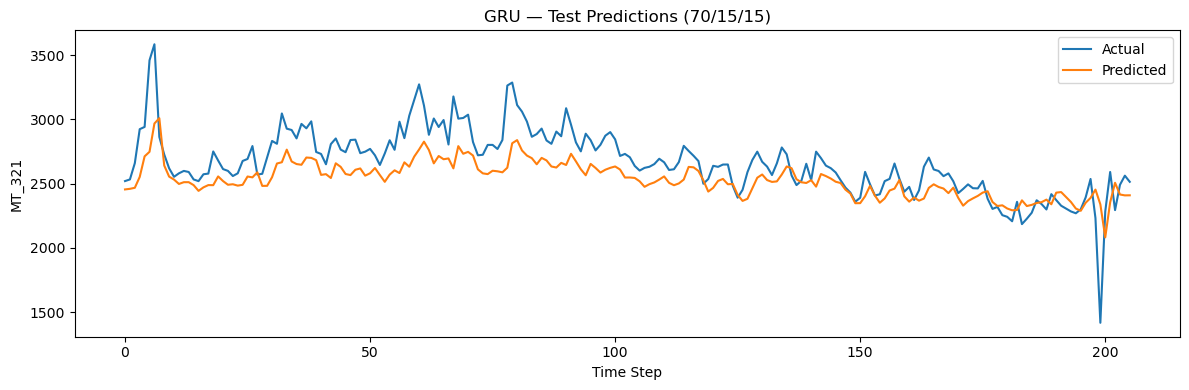

In [122]:
# -------------------- 1) Data & split (70/15/15, sequential) --------------------
features = ['MT_321', 'Avg_Temperature_C']
data = merged_df[features].dropna().copy().values
T = len(data)
n_train, n_val = int(T*0.70), int(T*0.15)

train_raw = data[:n_train]
val_raw   = data[n_train:n_train+n_val]
test_raw  = data[n_train+n_val:]

# Scale on TRAIN only
scaler = MinMaxScaler().fit(train_raw)
train = scaler.transform(train_raw)
val   = scaler.transform(val_raw)
test  = scaler.transform(test_raw)

target_idx = 0
tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

# -------------------- 2) Sequence creation --------------------
def create_sequences(arr, lookback, target_col_idx=0):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, :])
        y.append(arr[i, target_col_idx])
    return np.array(X), np.array(y)

lookback = 14
X_train, y_train = create_sequences(train, lookback, target_idx)
X_val,   y_val   = create_sequences(val,   lookback, target_idx)
X_test,  y_test  = create_sequences(test,  lookback, target_idx)

# -------------------- 3) Hyperparams --------------------
units = 50
batch_size = 32
dropout = 0.2
learning_rate = 1e-3
epochs = 100

# -------------------- 4) Model --------------------
model = Sequential([
    GRU(units=units, dropout=dropout, input_shape=(lookback, X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
model.summary()

# -------------------- 5) Train (no EarlyStopping) --------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs, batch_size=batch_size,
    shuffle=False, verbose=1
)

# -------------------- 6) Predict & inverse-scale --------------------
y_pred = model.predict(X_test).flatten()
y_test_inv = y_test * (tmax - tmin) + tmin
y_pred_inv = y_pred * (tmax - tmin) + tmin

# -------------------- 7) Metrics --------------------
mae  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2   = r2_score(y_test_inv, y_pred_inv)

print("\n📊 GRU (70/15/15) — No EarlyStopping")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

# (opsiyonel) hızlı çizim
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("GRU — Test Predictions (70/15/15)")
plt.xlabel("Time Step"); plt.ylabel("MT_321")
plt.legend(); plt.tight_layout(); plt.show()


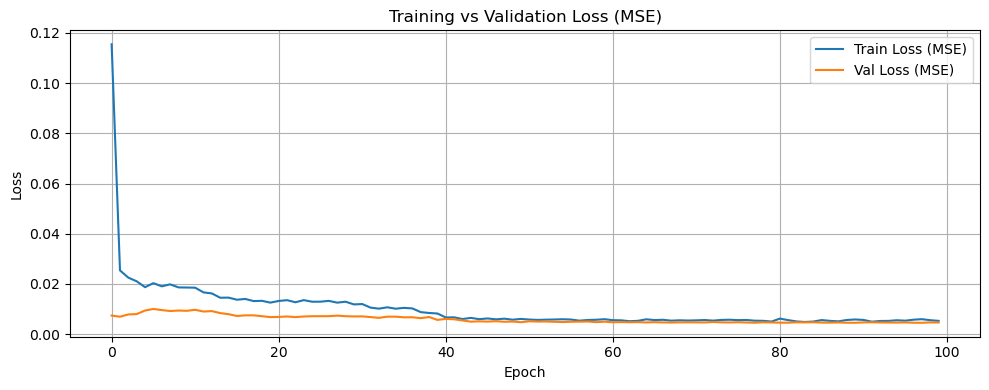

In [118]:
# ---- Training & Validation Loss (MSE) ----
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training vs Validation Loss (MSE)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


# GridSearch Tunning For GRU

In [131]:
# =====  GRU GridSearch (75/15/10 split) =====

SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

features   = ['MT_321', 'Avg_Temperature_C']
target_col = 'MT_321'
target_idx = features.index(target_col)

ACTIVATION = 'tanh'
EPOCHS     = 100
PATIENCE   = 8

LOOKBACKS      = [7, 14, 30]
UNITS_LIST     = [32, 64, 96]
BATCH_SIZES    = [16, 32, 64]
LEARNING_RATES = [1e-4, 5e-4, 1e-3]
WEIGHT_DECAYS  = [1e-6, 1e-5, 1e-4]
DROPOUTS       = [0.0]  # sabit

def temporal_split_idx_3(n, r_train=0.75, r_val=0.15):
    n_train = int(n*r_train)
    n_val   = int(n*r_val)
    n_test  = n - n_train - n_val
    return n_train, n_val, n_test

def create_sequences_from_array(arr2d, lookback, target_col_idx):
    X, y = [], []
    for i in range(len(arr2d) - lookback):
        X.append(arr2d[i:i+lookback, :])
        y.append(arr2d[i+lookback, target_col_idx])
    return np.array(X), np.array(y)

def gru_gridsearch_train_val(merged_df):
    data = merged_df[features].dropna().copy()
    T = len(data)
    n_train, n_val, n_test = temporal_split_idx_3(T, 0.75, 0.15)

    train_df = data.iloc[:n_train]
    val_df   = data.iloc[n_train:n_train+n_val]

    scaler = MinMaxScaler().fit(train_df.values)
    train_s = scaler.transform(train_df.values)
    val_s   = scaler.transform(val_df.values)

    tmin = scaler.data_min_[target_idx]; tmax = scaler.data_max_[target_idx]

    best_cfg, best_rmse = {}, float('inf')
    results = []
    total = (len(LOOKBACKS)*len(UNITS_LIST)*len(BATCH_SIZES)*
             len(LEARNING_RATES)*len(WEIGHT_DECAYS)*len(DROPOUTS))
    print(f"[GRID-GRU] rows={T} | train={n_train} val={n_val} test={n_test} | combos={total}")

    for lookback in LOOKBACKS:
        Xtr, ytr = create_sequences_from_array(train_s, lookback, target_idx)
        Xva, yva = create_sequences_from_array(val_s,   lookback, target_idx)
        if len(Xtr)==0 or len(Xva)==0: 
            continue

        for units in UNITS_LIST:
            for bs in BATCH_SIZES:
                for lr in LEARNING_RATES:
                    for wd in WEIGHT_DECAYS:
                        for do in DROPOUTS:
                            try:
                                model = Sequential([
                                    GRU(units, activation=ACTIVATION, dropout=do,
                                        input_shape=(lookback, len(features))),
                                    Dense(1)
                                ])
                                opt = Adam(learning_rate=lr, weight_decay=wd, clipnorm=1.0)
                                model.compile(optimizer=opt, loss='mse')
                                cb  = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                                                    restore_best_weights=True, verbose=0)

                                _ = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                                              epochs=EPOCHS, batch_size=bs, shuffle=False,
                                              verbose=0, callbacks=[cb])

                                yv_pred = model.predict(Xva, verbose=0).flatten()
                                yv_inv      = yva*(tmax-tmin)+tmin
                                yv_pred_inv = yv_pred*(tmax-tmin)+tmin

                                rmse = float(np.sqrt(mean_squared_error(yv_inv, yv_pred_inv)))
                                mae  = float(mean_absolute_error(yv_inv, yv_pred_inv))
                                r2   = float(r2_score(yv_inv, yv_pred_inv))

                                results.append({'lookback':lookback,'units':units,'batch_size':bs,
                                                'learning_rate':lr,'weight_decay':wd,'dropout':do,
                                                'val_rmse_real':rmse,'val_mae_real':mae,'val_r2':r2})
                                if rmse < best_rmse:
                                    best_rmse = rmse
                                    best_cfg = {'lookback':lookback,'units':units,'batch_size':bs,
                                                'learning_rate':lr,'weight_decay':wd,'dropout':do}
                            except tf.errors.ResourceExhaustedError:
                                print("⚠️ Skipped (OOM):", lookback, units, bs, lr, wd, do)
                            finally:
                                del model
                                K.clear_session()
                                gc.collect()

    df = (pd.DataFrame(results).sort_values('val_rmse_real').reset_index(drop=True)
          if results else pd.DataFrame())
    print("\n[A BLOK] Top-5:")
    print(df.head(5))
    print("\n[A BLOK] Best config:", best_cfg)
    return df, best_cfg


assert 'merged_df' in globals(), "merged_df is not defined."
assert set(features).issubset(merged_df.columns), f"Missing columns: {set(features)-set(merged_df.columns)}"
gru_results_df, gru_best_cfg = gru_gridsearch_train_val(merged_df)


[GRID-GRU] rows=1461 | train=1095 val=219 test=147 | combos=243



[A BLOK] Top-5:
   lookback  units  batch_size  learning_rate  weight_decay  dropout  \
0         7     96          64          0.001      0.000010      0.0   
1         7     64          64          0.001      0.000100      0.0   
2        14     32          32          0.001      0.000010      0.0   
3         7     64          64          0.001      0.000001      0.0   
4        14     96          64          0.001      0.000010      0.0   

   val_rmse_real  val_mae_real    val_r2  
0     106.029597     70.393583  0.772865  
1     106.172337     70.354758  0.772253  
2     106.280402     72.856803  0.776424  
3     106.282242     70.450521  0.771781  
4     106.534811     72.158851  0.775352  

[A BLOK] Best config: {'lookback': 7, 'units': 96, 'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'dropout': 0.0}


# GRU model with best GridSearch hyperamaters

[TEST 10% @75/15/10] RMSE:128.79  MAE:80.89  R²:0.7111


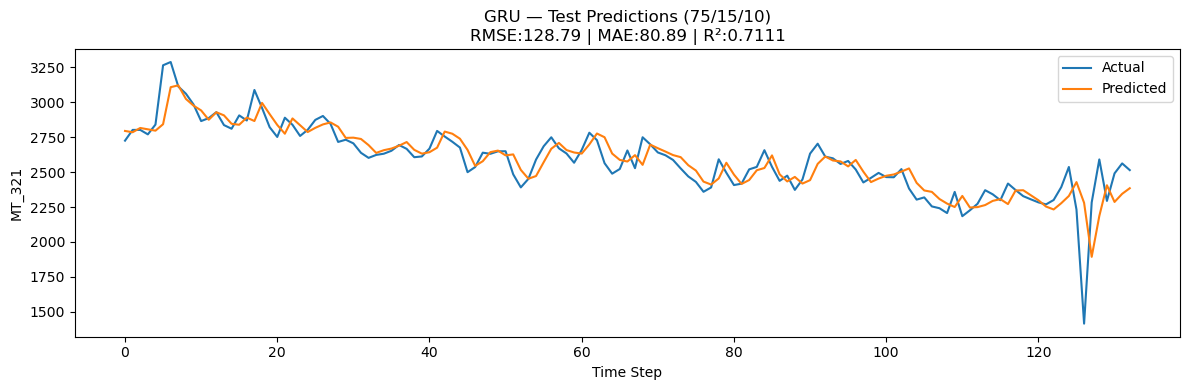

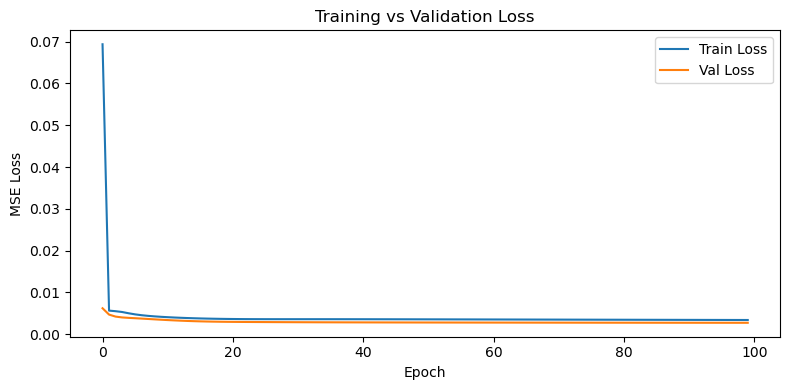

In [140]:
# ---- B Block: 75/15/10  (GRU, best cfg) ----
def gru_eval_on_test_75(merged_df, best_cfg):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import GRU, Dense
    from tensorflow.keras.optimizers import Adam

    
    features = ['MT_321','Avg_Temperature_C']; target_idx = 0
    data = merged_df[features].dropna().values
    T = len(data); n_train, n_val = int(T*0.75), int(T*0.15)
    train_raw = data[:n_train]; val_raw = data[n_train:n_train+n_val]; test_raw = data[n_train+n_val:]

    scaler = MinMaxScaler().fit(train_raw)
    train = scaler.transform(train_raw); val = scaler.transform(val_raw); test = scaler.transform(test_raw)
    tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

    def seq(a, L):
        X,y=[],[]
        for i in range(L,len(a)):
            X.append(a[i-L:i,:]); y.append(a[i,target_idx])
        return np.array(X), np.array(y)

    L = best_cfg['lookback']
    Xtr,ytr = seq(train,L); Xva,yva = seq(val,L); Xte,yte = seq(test,L)

    # --- Model kur ---
    model = Sequential([
        GRU(best_cfg['units'], dropout=best_cfg['dropout'], 
            input_shape=(L, len(features))),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=best_cfg['learning_rate'],
                                 weight_decay=best_cfg['weight_decay'], clipnorm=1.0),
                  loss='mse')

    # --- Train & history ---
    history = model.fit(np.concatenate([Xtr,Xva]), np.concatenate([ytr,yva]),
                        validation_data=(Xva,yva), epochs=100,
                        batch_size=best_cfg['batch_size'],
                        shuffle=False, verbose=0)

    # --- Predict & metrics ---
    y_pred = model.predict(Xte, verbose=0).flatten()
    y_true = yte*(tmax-tmin)+tmin
    y_hat  = y_pred*(tmax-tmin)+tmin

    rmse = float(np.sqrt(mean_squared_error(y_true, y_hat)))
    mae  = float(mean_absolute_error(y_true, y_hat))
    r2   = float(r2_score(y_true, y_hat))
    print(f"[TEST 10% @75/15/10] RMSE:{rmse:.2f}  MAE:{mae:.2f}  R²:{r2:.4f}")

    # --- Prediction graph ---
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label='Actual'); plt.plot(y_hat, label='Predicted')
    plt.title(f"GRU — Test Predictions (75/15/10)\nRMSE:{rmse:.2f} | MAE:{mae:.2f} | R²:{r2:.4f}")
    plt.xlabel("Time Step"); plt.ylabel("MT_321"); plt.legend(); plt.tight_layout(); plt.show()

    # --- Train vs Val loss graph ---
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend(); plt.tight_layout(); plt.show()

    return {'rmse':rmse,'mae':mae,'r2':r2}

# ==== ÇALIŞTIR (B BLOK) ====
best_cfg = {'lookback':14,'units':32,'batch_size':32,
            'learning_rate':0.001,'weight_decay':1e-5,'dropout':0.0}
test_metrics_75 = gru_eval_on_test_75(merged_df, best_cfg)

# ✅ GRU Random Search

In [124]:
# ------------------ 1. Reproducibility ------------------
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ------------------ 2. Hyperparameter Space ------------------
LOOKBACKS      = [7,10, 14, 30]
UNITS_LIST     = [32, 64, 96]
BATCH_SIZES    = [16, 32, 64]
LEARNING_RATES = [1e-4, 5e-4, 1e-3]
WEIGHT_DECAYS  = [1e-6, 1e-5, 1e-4]
DROPOUTS       = [0.0]   # fixed

ACTIVATION     = 'tanh'
EPOCHS         = 100
PATIENCE       = 8
N_ITERATIONS   = 100   #n times trail

features   = ['MT_321', 'Avg_Temperature_C']
target_col = 'MT_321'
target_idx = features.index(target_col)

# ------------------ 3. Sequence function ------------------
def create_sequences_from_array(arr2d, lookback, target_col_idx):
    X, y = [], []
    for i in range(len(arr2d) - lookback):
        X.append(arr2d[i:i+lookback, :])
        y.append(arr2d[i+lookback, target_col_idx])
    return np.array(X), np.array(y)

# ------------------ 4. Temporal Split (75/15/10) ------------------
def temporal_split_idx_3(n, r_train=0.75, r_val=0.15):
    n_train = int(n*r_train)
    n_val   = int(n*r_val)
    n_test  = n - n_train - n_val
    return n_train, n_val, n_test

# ------------------ 5. Random Search ------------------
def gru_randomsearch_train_val(merged_df, n_iter=N_ITERATIONS):
    data = merged_df[features].dropna().copy()
    T = len(data)
    n_train, n_val, n_test = temporal_split_idx_3(T, 0.75, 0.15)

    train_df = data.iloc[:n_train]
    val_df   = data.iloc[n_train:n_train+n_val]

    scaler = MinMaxScaler().fit(train_df.values)
    train_s = scaler.transform(train_df.values)
    val_s   = scaler.transform(val_df.values)

    tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

    results, best_cfg, best_rmse = [], {}, float('inf')
    print(f"[RANDOM-GRU] rows={T} | train={n_train} val={n_val} test={n_test} | iterations={n_iter}")

    for it in range(n_iter):
        # --- Random HP seç ---
        lookback = random.choice(LOOKBACKS)
        units    = random.choice(UNITS_LIST)
        bs       = random.choice(BATCH_SIZES)
        lr       = random.choice(LEARNING_RATES)
        wd       = random.choice(WEIGHT_DECAYS)
        do       = random.choice(DROPOUTS)

        # --- Sequence ---
        Xtr,ytr = create_sequences_from_array(train_s, lookback, target_idx)
        Xva,yva = create_sequences_from_array(val_s,   lookback, target_idx)
        if len(Xtr)==0 or len(Xva)==0:
            continue

        try:
            # --- Model ---
            model = Sequential([
                GRU(units, activation=ACTIVATION, dropout=do,
                    input_shape=(lookback, len(features))),
                Dense(1)
            ])
            opt = Adam(learning_rate=lr, weight_decay=wd, clipnorm=1.0)
            model.compile(optimizer=opt, loss='mse')
            cb  = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                                restore_best_weights=True, verbose=0)

            # --- Train ---
            _ = model.fit(Xtr, ytr, validation_data=(Xva,yva),
                          epochs=EPOCHS, batch_size=bs, shuffle=False,
                          verbose=0, callbacks=[cb])

            # --- Predict & inverse scale ---
            yv_pred = model.predict(Xva, verbose=0).flatten()
            yv_inv      = yva*(tmax-tmin)+tmin
            yv_pred_inv = yv_pred*(tmax-tmin)+tmin

            rmse = float(np.sqrt(mean_squared_error(yv_inv, yv_pred_inv)))
            mae  = float(mean_absolute_error(yv_inv, yv_pred_inv))
            r2   = float(r2_score(yv_inv, yv_pred_inv))

            results.append({'lookback':lookback,'units':units,'batch_size':bs,
                            'learning_rate':lr,'weight_decay':wd,'dropout':do,
                            'val_rmse_real':rmse,'val_mae_real':mae,'val_r2':r2})

            if rmse < best_rmse:
                best_rmse = rmse
                best_cfg = {'lookback':lookback,'units':units,'batch_size':bs,
                            'learning_rate':lr,'weight_decay':wd,'dropout':do}

        except tf.errors.ResourceExhaustedError:
            print("⚠️ Skipped (OOM):", lookback, units, bs, lr, wd, do)
        finally:
            del model
            K.clear_session()
            gc.collect()

    df = (pd.DataFrame(results).sort_values('val_rmse_real').reset_index(drop=True)
          if results else pd.DataFrame())
    print("\n[RANDOM BLOK] Top-5:")
    print(df.head(5))
    print("\n[RANDOM BLOK] Best config:", best_cfg)
    return df, best_cfg



gru_rand_results_df, gru_rand_best_cfg = gru_randomsearch_train_val(merged_df, n_iter=100)

[RANDOM-GRU] rows=1461 | train=1095 val=219 test=147 | iterations=100



[RANDOM BLOK] Top-5:
   lookback  units  batch_size  learning_rate  weight_decay  dropout  \
0         7     96          32         0.0005      0.000001      0.0   
1        14     64          64         0.0010      0.000100      0.0   
2         7     96          64         0.0010      0.000001      0.0   
3        14     96          64         0.0010      0.000001      0.0   
4        10     64          32         0.0005      0.000100      0.0   

   val_rmse_real  val_mae_real    val_r2  
0     106.542430     72.392749  0.770662  
1     106.760453     72.222712  0.774400  
2     106.792093     70.857171  0.769586  
3     107.023840     72.888490  0.773285  
4     107.077024     72.942422  0.770198  

[RANDOM BLOK] Best config: {'lookback': 7, 'units': 96, 'batch_size': 32, 'learning_rate': 0.0005, 'weight_decay': 1e-06, 'dropout': 0.0}


# GRU BEST MODEL RANDOM SEARCH

[TEST 10% @75/15/10] RMSE:131.70  MAE:83.60  R²:0.7182


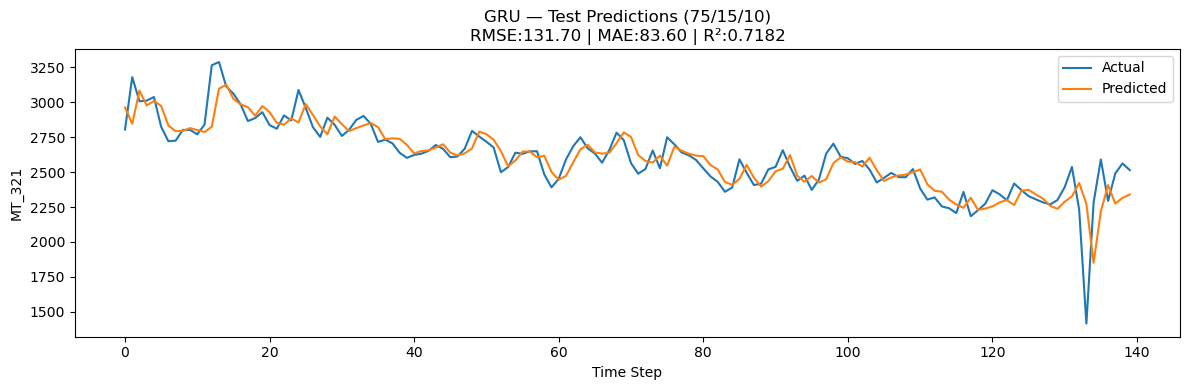

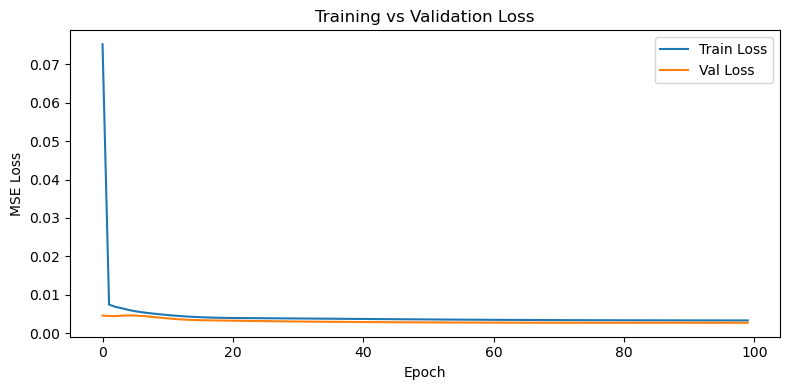

In [75]:
def gru_eval_on_test_75(merged_df, best_cfg):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import GRU, Dense
    from tensorflow.keras.optimizers import Adam

    # --- Data Preperation ---
    features = ['MT_321','Avg_Temperature_C']; target_idx = 0
    data = merged_df[features].dropna().values
    T = len(data); n_train, n_val = int(T*0.75), int(T*0.15)
    train_raw = data[:n_train]; val_raw = data[n_train:n_train+n_val]; test_raw = data[n_train+n_val:]

    scaler = MinMaxScaler().fit(train_raw)
    train = scaler.transform(train_raw); val = scaler.transform(val_raw); test = scaler.transform(test_raw)
    tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

    def seq(a, L):
        X,y=[],[]
        for i in range(L,len(a)):
            X.append(a[i-L:i,:]); y.append(a[i,target_idx])
        return np.array(X), np.array(y)

    L = best_cfg['lookback']
    Xtr,ytr = seq(train,L); Xva,yva = seq(val,L); Xte,yte = seq(test,L)

    # --- Model  ---
    model = Sequential([
        GRU(best_cfg['units'], dropout=best_cfg['dropout'], 
            input_shape=(L, len(features))),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=best_cfg['learning_rate'],
                                 weight_decay=best_cfg['weight_decay'], clipnorm=1.0),
                  loss='mse')

    # --- Train & history ---
    history = model.fit(np.concatenate([Xtr,Xva]), np.concatenate([ytr,yva]),
                        validation_data=(Xva,yva), epochs=100,
                        batch_size=best_cfg['batch_size'],
                        shuffle=False, verbose=0)

    # --- Predict & metrics ---
    y_pred = model.predict(Xte, verbose=0).flatten()
    y_true = yte*(tmax-tmin)+tmin
    y_hat  = y_pred*(tmax-tmin)+tmin

    rmse = float(np.sqrt(mean_squared_error(y_true, y_hat)))
    mae  = float(mean_absolute_error(y_true, y_hat))
    r2   = float(r2_score(y_true, y_hat))
    print(f"[TEST 10% @75/15/10] RMSE:{rmse:.2f}  MAE:{mae:.2f}  R²:{r2:.4f}")

    # --- Prediction graph ---
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label='Actual'); plt.plot(y_hat, label='Predicted')
    plt.title(f"GRU — Test Predictions (75/15/10)\nRMSE:{rmse:.2f} | MAE:{mae:.2f} | R²:{r2:.4f}")
    plt.xlabel("Time Step"); plt.ylabel("MT_321"); plt.legend(); plt.tight_layout(); plt.show()

    # --- Train vs Val loss graph ---
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend(); plt.tight_layout(); plt.show()

    return {'rmse':rmse,'mae':mae,'r2':r2}



best_cfg = {'lookback':7,'units':96,'batch_size':32,
            'learning_rate':0.0005,'weight_decay':1e-6,'dropout':0.0}
test_metrics_75 = gru_eval_on_test_75(merged_df, best_cfg)

# GRU MODEL OPTUNA 

In [126]:
# ===== GRU + Optuna (70/15/10 split) =====
import numpy as np, pandas as pd, time, random, os, optuna, gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# ------------------------ 0) Reproducibility ------------------------
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ------------------------ 1) Data & Split (70/15/10) ------------------------
features = ['MT_321', 'Avg_Temperature_C']
df = merged_df[features].dropna().copy()
T = len(df)
n_train = int(T*0.75)
n_val   = int(T*0.15)
n_test  = T - n_train - n_val

train_raw = df.iloc[:n_train].values
val_raw   = df.iloc[n_train:n_train+n_val].values
test_raw  = df.iloc[n_train+n_val:].values   

# scaler yalnızca TRAIN'de fit
scaler = MinMaxScaler().fit(train_raw)
train_s = scaler.transform(train_raw)
val_s   = scaler.transform(val_raw)
target_idx = 0
tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

# ------------------------ 2) Sequence helper ------------------------
def make_seq(arr2d, lookback, target_col_idx=0):
    X, y = [], []
    for i in range(lookback, len(arr2d)):
        X.append(arr2d[i-lookback:i, :])
        y.append(arr2d[i, target_col_idx])
    return np.array(X), np.array(y)

# ------------------------ 3) Optuna Objective ------------------------
training_times = {}

def objective(trial):
    # ---- HP space ----
    lookback      = trial.suggest_categorical("lookback",      [7, 14, 21, 30])
    units         = trial.suggest_categorical("units",         [32, 64, 96, 128])
    batch_size    = trial.suggest_categorical("batch_size",    [16, 32, 64])
    learning_rate = trial.suggest_categorical("learning_rate", [1e-4, 3e-4, 5e-4, 1e-3])
    weight_decay  = trial.suggest_categorical("weight_decay",  [1e-6, 1e-5, 3e-5, 1e-4])
    activation    = 'tanh'
    dropout       = 0.0   # sabit
    EPOCHS, PATIENCE = 100, 8

    # ---- Sequences ----
    Xtr, ytr = make_seq(train_s, lookback, target_idx)
    Xva, yva = make_seq(val_s,   lookback, target_idx)
    if len(Xtr)==0 or len(Xva)==0:
        return float("inf")

    # ---- Model ----
    model = Sequential([
        Input(shape=(lookback, train_s.shape[1])),
        GRU(units=units, activation=activation, dropout=dropout),
        Dense(1)
    ])
    opt = Adam(learning_rate=learning_rate, weight_decay=weight_decay, clipnorm=1.0)
    model.compile(optimizer=opt, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)

    # ---- Train (timed) ----
    t0 = time.time()
    _ = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                  epochs=EPOCHS, batch_size=batch_size,
                  shuffle=False, verbose=0, callbacks=[es])
    training_times[trial.number] = time.time() - t0

    # ---- Val prediction (inverse-scale target) ----
    y_pred = model.predict(Xva, verbose=0).flatten()
    y_true_inv = yva*(tmax - tmin) + tmin
    y_pred_inv = y_pred*(tmax - tmin) + tmin
    rmse = float(np.sqrt(mean_squared_error(y_true_inv, y_pred_inv)))

    # temizlik
    del model, Xtr, ytr, Xva, yva, y_pred
    K.clear_session(); gc.collect()

    return rmse

# ------------------------ 4) Run Optuna Study ------------------------
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100)  

# ------------------------ 5) Show Best Result ------------------------
best_trial = study.best_trial
print("\n🎯 Best GRU Trial (70/15/10):")
print(f"Validation RMSE (real scale): {best_trial.value:.2f}")
for k, v in best_trial.params.items():
    print(f"{k}: {v}")
print(f"⏱ Training time: {training_times.get(best_trial.number, float('nan')):.2f} s")


[I 2025-09-02 00:53:20,832] A new study created in memory with name: no-name-87afb446-d5fe-42e0-a371-60d7b1419eb4
[I 2025-09-02 00:53:33,070] Trial 0 finished with value: 139.75356347718824 and parameters: {'lookback': 14, 'units': 128, 'batch_size': 32, 'learning_rate': 0.0001, 'weight_decay': 3e-05}. Best is trial 0 with value: 139.75356347718824.
[I 2025-09-02 00:53:44,754] Trial 1 finished with value: 135.86263493100128 and parameters: {'lookback': 14, 'units': 96, 'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 1e-06}. Best is trial 1 with value: 135.86263493100128.
[I 2025-09-02 00:54:05,517] Trial 2 finished with value: 112.82546657438148 and parameters: {'lookback': 7, 'units': 64, 'batch_size': 64, 'learning_rate': 0.0003, 'weight_decay': 3e-05}. Best is trial 2 with value: 112.82546657438148.
[I 2025-09-02 00:54:15,364] Trial 3 finished with value: 143.89631990069643 and parameters: {'lookback': 30, 'units': 64, 'batch_size': 64, 'learning_rate': 0.0003, 'weight_dec


🎯 Best GRU Trial (70/15/10):
Validation RMSE (real scale): 105.64
lookback: 7
units: 128
batch_size: 64
learning_rate: 0.001
weight_decay: 1e-05
⏱ Training time: 23.98 s


[TEST 10% @70/15/10] RMSE:131.78  MAE:82.32  R²:0.7178


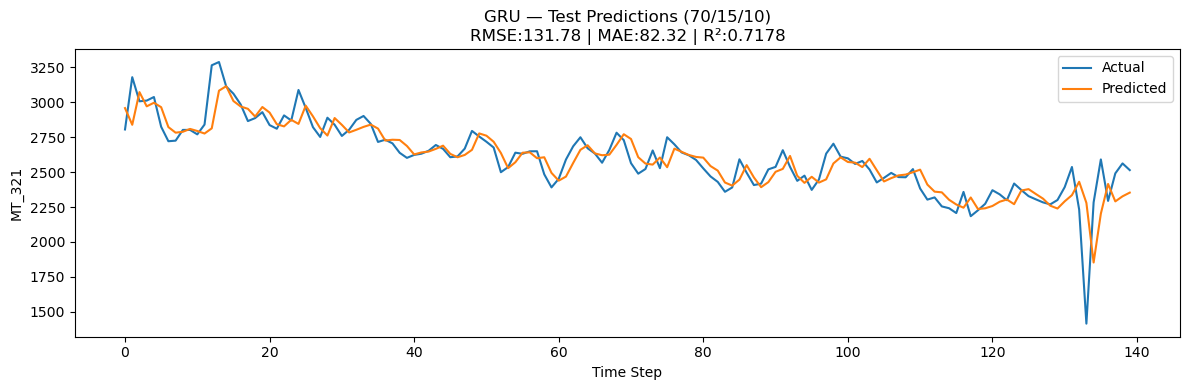

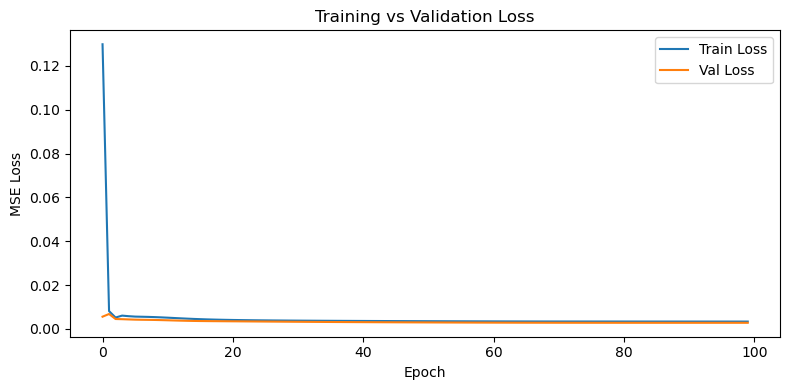

In [105]:
#  75/15/10 (GRU, Optuna best cfg) ----
def gru_eval_on_test_70(merged_df, best_cfg):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import GRU, Dense
    from tensorflow.keras.optimizers import Adam

    features = ['MT_321','Avg_Temperature_C']; target_idx = 0
    data = merged_df[features].dropna().values
    T = len(data); n_train, n_val = int(T*0.75), int(T*0.15)
    train_raw = data[:n_train]; val_raw = data[n_train:n_train+n_val]; test_raw = data[n_train+n_val:]

    scaler = MinMaxScaler().fit(train_raw)
    train = scaler.transform(train_raw); val = scaler.transform(val_raw); test = scaler.transform(test_raw)
    tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]
/
    def seq(a, L):
        X,y=[],[]
        for i in range(L,len(a)):
            X.append(a[i-L:i,:]); y.append(a[i,target_idx])
        return np.array(X), np.array(y)

    L = best_cfg['lookback']
    Xtr,ytr = seq(train,L); Xva,yva = seq(val,L); Xte,yte = seq(test,L)

    model = Sequential([
        GRU(best_cfg['units'], dropout=best_cfg['dropout'], input_shape=(L, len(features))),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=best_cfg['learning_rate'],
                                 weight_decay=best_cfg['weight_decay'], clipnorm=1.0),
                  loss='mse')

    history = model.fit(np.concatenate([Xtr,Xva]), np.concatenate([ytr,yva]),
                        validation_data=(Xva,yva),
                        epochs=100, batch_size=best_cfg['batch_size'],
                        shuffle=False, verbose=0)

    y_pred = model.predict(Xte, verbose=0).flatten()
    y_true = yte*(tmax-tmin)+tmin
    y_hat  = y_pred*(tmax-tmin)+tmin

    rmse = float(np.sqrt(mean_squared_error(y_true, y_hat)))
    mae  = float(mean_absolute_error(y_true, y_hat))
    r2   = float(r2_score(y_true, y_hat))
    print(f"[TEST 10% @70/15/10] RMSE:{rmse:.2f}  MAE:{mae:.2f}  R²:{r2:.4f}")

    # Prediction graph
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label='Actual'); plt.plot(y_hat, label='Predicted')
    plt.title(f"GRU — Test Predictions (70/15/10)\nRMSE:{rmse:.2f} | MAE:{mae:.2f} | R²:{r2:.4f}")
    plt.xlabel("Time Step"); plt.ylabel("MT_321"); plt.legend(); plt.tight_layout(); plt.show()

    # Train vs Val loss
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend(); plt.tight_layout(); plt.show()

    return {'rmse':rmse,'mae':mae,'r2':r2}


best_cfg = {'lookback':7,'units':128,'batch_size':64,
            'learning_rate':0.001,'weight_decay':1e-5,'dropout':0.0}
test_metrics_70 = gru_eval_on_test_70(merged_df, best_cfg)

# Gru KerasTuner (Bayesian Optimization) 

In [81]:
import numpy as np, pandas as pd, os, time, shutil, random, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt

# ------------------------ 0. Reproducibility ------------------------
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# ------------------------ 1. Data Preparation ------------------------
features = ['MT_321', 'Avg_Temperature_C']
data = merged_df[features].dropna().values

T = len(data)
n_train, n_val = int(T*0.75), int(T*0.15)
train_raw, val_raw = data[:n_train], data[n_train:n_train+n_val]

scaler = MinMaxScaler().fit(train_raw)
train_s, val_s = scaler.transform(train_raw), scaler.transform(val_raw)
tmin, tmax = scaler.data_min_[0], scaler.data_max_[0]   # target: MT_321
n_features = train_s.shape[1]

# ------------------------ 2. Sequence Function ------------------------
def make_seq(a, L, target_idx=0):
    X, y = [], []
    for i in range(L, len(a)):
        X.append(a[i-L:i,:]); y.append(a[i,target_idx])
    return np.array(X), np.array(y)

# ------------------------ 3. Model Builder ------------------------
def build_model(hp):
    units = hp.Choice("units", [32, 64, 96, 128])
    dropout = 0.0
    lr = hp.Choice("learning_rate", [1e-4, 3e-4, 5e-4, 1e-3])
    wd = hp.Choice("weight_decay", [1e-6, 1e-5, 3e-5, 1e-4])

    model = Sequential([
        Input(shape=(None, n_features)),
        GRU(units=units, activation='tanh', dropout=dropout),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr, weight_decay=wd, clipnorm=1.0)

    model.compile(optimizer=optimizer, loss="mse")
    return model

# ------------------------ 4. Custom Tuner ------------------------
training_times = {}

class LookbackTuner(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        lookback = hp.Choice("lookback", [7, 14, 21, 30])
        batch_size = hp.Choice("batch_size", [16, 32, 64])

        Xtr,ytr = make_seq(train_s, lookback)
        Xva,yva = make_seq(val_s, lookback)

        model = self.hypermodel.build(hp)
        es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

        start = time.time()
        model.fit(Xtr,ytr,
                  validation_data=(Xva,yva),
                  epochs=100, batch_size=batch_size,
                  verbose=0, callbacks=[es])
        end = time.time()
        training_times[trial.trial_id] = end - start

        # --- Evaluate on validation (real-scale RMSE) ---
        y_pred = model.predict(Xva, verbose=0).flatten()
        y_true_inv = yva*(tmax-tmin)+tmin
        y_pred_inv = y_pred*(tmax-tmin)+tmin
        val_rmse = float(np.sqrt(mean_squared_error(y_true_inv,y_pred_inv)))
        return val_rmse

# ------------------------ 5. Run Tuner ------------------------
tuner_dir = os.path.join(os.path.expanduser("~"), "Desktop", "gru_tuner_bayes_valrmse")
shutil.rmtree(tuner_dir, ignore_errors=True)

tuner = LookbackTuner(
    build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory=tuner_dir,
    project_name="gru_bayesian"
)

tuner.search(epochs=100, verbose=1)

# ------------------------ 6. Best Result ------------------------
best_hp = tuner.get_best_hyperparameters(1)[0]
best_trial = tuner.oracle.get_best_trials(1)[0]
print("\n✅ Best Hyperparameters (GRU Bayesian, 75/15/10):")
for p in best_hp.values: 
    print(f"{p}: {best_hp.get(p)}")

print(f"\n✅ Validation RMSE (real scale): {best_trial.score:.2f}")
print(f"⏱ Training time (best trial {best_trial.trial_id}): {training_times[best_trial.trial_id]:.2f} s")


Trial 100 Complete [00h 00m 27s]
val_rmse: 107.01599309165877

Best val_rmse So Far: 105.98001684797559
Total elapsed time: 00h 47m 51s

✅ Best Hyperparameters (GRU Bayesian, 75/15/10):
units: 96
learning_rate: 0.001
weight_decay: 0.0001
lookback: 14
batch_size: 16

✅ Validation RMSE (real scale): 105.98
⏱ Training time (best trial 031): 29.27 s



📊 Final GRU (Bayesian, 75/15/10)
RMSE: 126.77 | MAE: 82.41 | R²: 0.7201


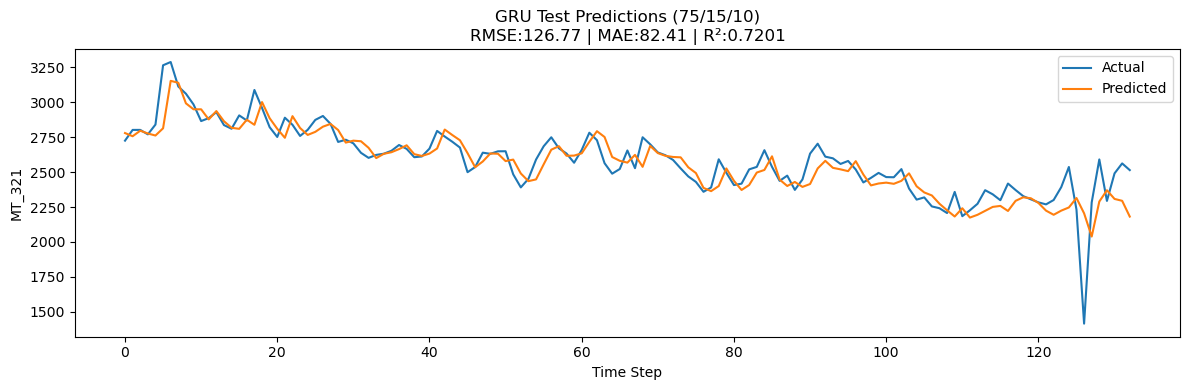

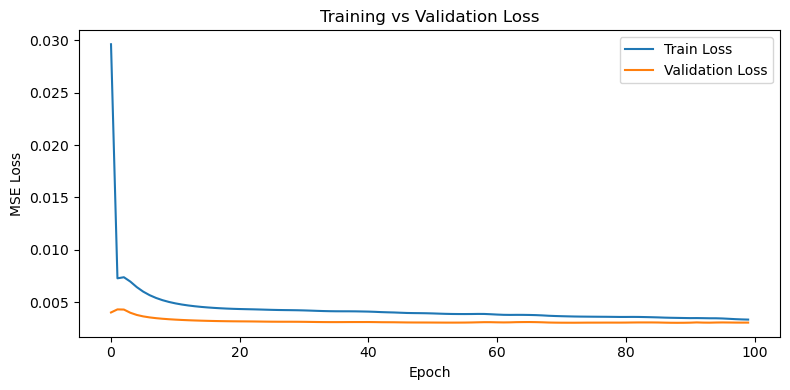

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.optimizers import Adam

# ===========================
# Final evaluation function
# ===========================
def gru_final_eval(merged_df, best_cfg):
    features = ['MT_321','Avg_Temperature_C']
    target_idx = 0
    data = merged_df[features].dropna().values

    # 75 / 15 / 10 split
    T = len(data)
    n_train, n_val = int(T*0.75), int(T*0.15)
    train_raw = data[:n_train]
    val_raw   = data[n_train:n_train+n_val]
    test_raw  = data[n_train+n_val:]

    # scaling with train only
    scaler = MinMaxScaler().fit(train_raw)
    train = scaler.transform(train_raw)
    val   = scaler.transform(val_raw)
    test  = scaler.transform(test_raw)

    tmin, tmax = scaler.data_min_[target_idx], scaler.data_max_[target_idx]

    def seq(a, L):
        X, y = [], []
        for i in range(L, len(a)):
            X.append(a[i-L:i,:])
            y.append(a[i, target_idx])
        return np.array(X), np.array(y)

    L = best_cfg['lookback']
    Xtr, ytr = seq(train, L)
    Xva, yva = seq(val, L)
    Xte, yte = seq(test, L)

    # ------------------- Model -------------------
    model = Sequential([
        Input(shape=(L, len(features))),
        GRU(best_cfg['units'], activation='tanh', dropout=0.0),
        Dense(1)
    ])

    optimizer = Adam(
        learning_rate=best_cfg['learning_rate'],
        weight_decay=best_cfg['weight_decay'],
        clipnorm=1.0
    )

    model.compile(optimizer=optimizer, loss="mse")

    # ------------------- Training -------------------
    history = model.fit(
        np.concatenate([Xtr, Xva]), np.concatenate([ytr, yva]),
        validation_data=(Xva, yva),
        epochs=100,
        batch_size=best_cfg['batch_size'],
        shuffle=False,
        verbose=0
    )

    # ------------------- Predictions -------------------
    y_pred = model.predict(Xte, verbose=0).flatten()

    # inverse transform
    y_true = yte * (tmax - tmin) + tmin
    y_hat  = y_pred * (tmax - tmin) + tmin

    rmse = float(np.sqrt(mean_squared_error(y_true, y_hat)))
    mae  = float(mean_absolute_error(y_true, y_hat))
    r2   = float(r2_score(y_true, y_hat))

    print(f"\n📊 Final GRU (Bayesian, 75/15/10)")
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

    # ------------------- Graphs -------------------
    # 1. Predictions vs Actual
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_hat, label="Predicted")
    plt.title(f"GRU Test Predictions (75/15/10)\nRMSE:{rmse:.2f} | MAE:{mae:.2f} | R²:{r2:.4f}")
    plt.xlabel("Time Step"); plt.ylabel("MT_321")
    plt.legend(); plt.tight_layout(); plt.show()

    # 2. Train vs Validation Loss
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.legend(); plt.tight_layout(); plt.show()

    return {"rmse":rmse, "mae":mae, "r2":r2}
    


# ===========================
# Run Final Evaluation
# ===========================
best_cfg = {
    'lookback': 14,
    'units': 96,
    'batch_size': 16,
    'learning_rate': 0.001,
    'weight_decay': 1e-4
}

final_metrics = gru_final_eval(merged_df, best_cfg)